# Prädiktive Analyse von Schilddrüsenkarzinom-Rezidiven
Vorhersage und Analyse des Wiederauftretens differenzierter Schilddrüsenkarzinome mit maschinellem Lernen


# 1 Problemformulierung

In [752]:
# Ziel: Vorhersage eines Rezidivs bei differenziertem Schilddrüsenkrebs

# Die Zielvariable ist 'Recurred':
# 'Yes/1' bedeutet, dass der Krebs nach der Behandlung zurückgekehrt ist.
# 'No/0' bedeutet, dass kein Rückfall aufgetreten ist.

# Maschinelles Lernen soll helfen, Patientengruppen mit erhöhtem Rückfallrisiko zu erkennen.
# Dies könnte in der klinischen Praxis genutzt werden, um intensivere Nachsorge durchzuführen.

# Ziel des Projekts:
# Ein Klassifikationsmodell entwickeln, das das Risiko eines Rückfalls (Rezidivs) basierend auf Patientenmerkmalen vorhersagt.


In [753]:
# ===================================================
# Allgemeine Bibliotheken
# ===================================================
import os
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import interp
from IPython.display import Image, display, Markdown

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(style="whitegrid")

# ===================================================
# Interaktive Visualisierung
# ===================================================
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# ===================================================
# Vorverarbeitung
# ===================================================
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ===================================================
# Modellierung
# ===================================================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree as xgb_plot_tree
from sklearn.neural_network import MLPClassifier

# ===================================================
# Modellbewertung
# ===================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, ConfusionMatrixDisplay
)
import scikitplot as skplt

# ===================================================
# Validierung & Hyperparameter-Tuning
# ===================================================
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score,
    StratifiedKFold, KFold, learning_curve, validation_curve
)
from sklearn.metrics import make_scorer

# ===================================================
# Statistische Analyse
# ===================================================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import boxcox, chi2_contingency

# ===================================================
# Umgang mit Imbalancierten Daten
# ===================================================
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

# ===================================================
# Explainable AI (XAI)
# ===================================================
import shap
import lime
import lime.lime_tabular


In [754]:
# ===================================================
# Daten laden
# ===================================================
df = pd.read_csv("Differentiated Thyroid Cancer Recurrence - UCI Machine Learning Repository (Thyroid_Diff).csv")


In [755]:
# Ursprüngliche Kopie für spätere Vergleiche speichern
df_orig = df.copy()

In [756]:
print(f"\n Datenform (Zeilen, Spalten): {df.shape}")



 Datenform (Zeilen, Spalten): (383, 17)


In [757]:
print("=== Datenexploration ===")
print("\nForm:", df.shape)
print("\nErste 5 Zeilen:")
display(df.head())

print("\nDatenübersicht:")
df.info()


=== Datenexploration ===

Form: (383, 17)

Erste 5 Zeilen:


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No



Datenübersicht:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              3

In [758]:
print("\n Statistische Übersicht:")
display(df.describe())



 Statistische Übersicht:


,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


In [759]:
print("\n Spaltennamen:")
print(df.columns)



 Spaltennamen:
Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')


In [760]:
print("\nFehlende Werte pro Spalte:")
print(df.isnull().sum())



Fehlende Werte pro Spalte:
Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64


In [761]:
# Numerische Spalten extrahieren
numerisch = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerische Spalten:")
print(numerisch)

# Kategorische Spalten extrahieren
kategorisch = df.select_dtypes(include=['object']).columns.tolist()
print("\nKategorische Spalten:")
print(kategorisch)


Numerische Spalten:
['Age']

Kategorische Spalten:
['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred']


In [762]:
# Neu einlesen, um alle Originalwerte zurückzubekommen
df = pd.read_csv("Differentiated Thyroid Cancer Recurrence - UCI Machine Learning Repository (Thyroid_Diff).csv")

# Binary: Nur zwei Werte → 0/1-Codierung (Label-Encoding)
binary_spalten = [
    "Gender",                # F / M
    "Smoking",               # No / Yes
    "Hx Smoking",            # No / Yes
    "Hx Radiothreapy",       # No / Yes
    "Adenopathy",            # No / Yes
    "Focality",              # Uni-Focal / Multi-Focal
    "Recurred"               # Zielvariable: No / Yes
]

# Ordinal: Geordnete Werte → Label-Encoding sinnvoll
ordinal_spalten = [
    "Risk",                  # Low < Intermediate < High
    "T",                     # T1a < T1b < T2 < T3 < T4
    "N",                     # N0 < N1a < N1b
    "M",                     # M0 < M1
    "Stage"                  # I < II < III < IV
]

# Nominal: Keine Reihenfolge → One-Hot-Encoding notwendig
nominal_spalten = [
    "Thyroid Function",
    "Physical Examination",
    "Pathology",
    "Response"
]


In [763]:
# Dictionary für binäre Kodierung
binary_mapping = {'No': 0, 'Yes': 1, 'F': 0, 'M': 1, 'Uni-Focal': 0, 'Multi-Focal': 1}

# Liste der binären Spalten
binary_spalten = [
    "Gender",
    "Smoking",
    "Hx Smoking",
    "Hx Radiothreapy",
    "Focality",
    "Recurred"
]

# Anwendung der Kodierung mit .str.strip()
for spalte in binary_spalten:
    df[spalte] = df[spalte].astype(str).str.strip().map(binary_mapping)

# Kontrolle der binär kodierten Spalten
print("Erste 5 Zeilen der binär kodierten Spalten (korrigiert):")
print(df[binary_spalten].head())


Erste 5 Zeilen der binär kodierten Spalten (korrigiert):
   Gender  Smoking  Hx Smoking  Hx Radiothreapy  Focality  Recurred
0       0        0           0                0         0         0
1       0        0           1                0         0         0
2       0        0           0                0         0         0
3       0        0           0                0         0         0
4       0        0           0                0         1         0


In [764]:
# Für jede binäre Spalte: eindeutige Werte anzeigen
binary_spalten = [
    "Gender",
    "Smoking",
    "Hx Smoking",
    "Hx Radiothreapy",
    "Focality",
    "Recurred"
]

for spalte in binary_spalten:
    print(f"\nEinzigartige Werte in '{spalte}':")
    print(df[spalte].unique())



Einzigartige Werte in 'Gender':
[0 1]

Einzigartige Werte in 'Smoking':
[0 1]

Einzigartige Werte in 'Hx Smoking':
[0 1]

Einzigartige Werte in 'Hx Radiothreapy':
[0 1]

Einzigartige Werte in 'Focality':
[0 1]

Einzigartige Werte in 'Recurred':
[0 1]


In [765]:
# Mapping für ordinal skalierte Spalten
risk_map = {'Low': 0, 'Intermediate': 1, 'High': 2}
t_map = {'T1a': 0, 'T1b': 1, 'T2': 2, 'T3': 3, 'T4a': 4, 'T4b': 5}
n_map = {'N0': 0, 'N1a': 1, 'N1b': 2}
m_map = {'M0': 0, 'M1': 1}
stage_map = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}

# Anwendung der Mappings
df['Risk'] = df['Risk'].map(risk_map)
df['T'] = df['T'].map(t_map)
df['N'] = df['N'].map(n_map)
df['M'] = df['M'].map(m_map)
df['Stage'] = df['Stage'].map(stage_map)

# Kontrolle der Kodierung
print("Erste 5 Zeilen der ordinal kodierten Spalten:")
print(df[['Risk', 'T', 'N', 'M', 'Stage']].head())


Erste 5 Zeilen der ordinal kodierten Spalten:
   Risk    T  N  M  Stage
0     0  0.0  0  0    0.0
1     0  0.0  0  0    0.0
2     0  0.0  0  0    0.0
3     0  0.0  0  0    0.0
4     0  0.0  0  0    0.0


In [766]:
# Liste der nominalen Spalten
nominale_spalten = [
    "Adenopathy",
    "Response",
    "Pathology",
    "Thyroid Function",
    "Physical Examination"
]

# One-Hot-Encoding anwenden
df = pd.get_dummies(df, columns=nominale_spalten, drop_first=True)

# Ergebnis anzeigen
print("Shape des DataFrames nach One-Hot-Encoding:", df.shape)
print("\nErste 5 Spaltennamen nach Encoding:")
print(df.columns[:10].tolist())


Shape des DataFrames nach One-Hot-Encoding: (383, 31)

Erste 5 Spaltennamen nach Encoding:
['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Focality', 'Risk', 'T', 'N', 'M']


# 2 Explorative Datenanalyse & Zielvariable & Verteilung

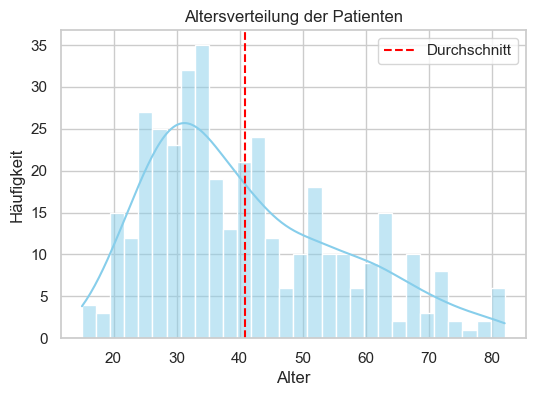

In [768]:
df.columns = df.columns.str.lower().str.strip()


plt.figure(figsize=(6, 4))
sns.histplot(df['age'], kde=True, bins=30, color="skyblue")
plt.title("Altersverteilung der Patienten")
plt.xlabel("Alter")
plt.ylabel("Häufigkeit")
plt.axvline(df['age'].mean(), color='red', linestyle='--', label='Durchschnitt')
plt.legend()
plt.show()


Verteilung der Zielvariable 'Recurred':
recurred
0    275
1    108
Name: count, dtype: int64

Prozentuale Verteilung:
recurred
0    71.801567
1    28.198433
Name: proportion, dtype: float64


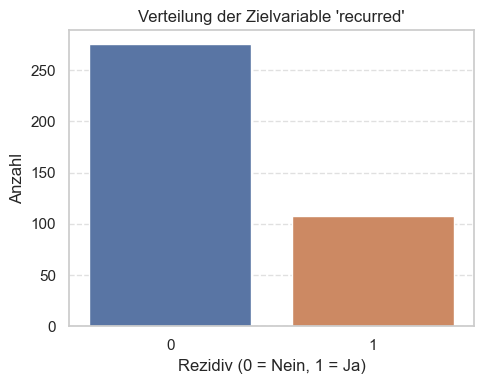

In [769]:
# Zielvariable: 'Recurred'
print("Verteilung der Zielvariable 'Recurred':")
print(df['recurred'].value_counts())

# Prozentuale Verteilung
print("\nProzentuale Verteilung:")
print(df['recurred'].value_counts(normalize=True) * 100)

# Balkendiagramm zur Verteilung
plt.figure(figsize=(5, 4))
sns.countplot(x='recurred', data=df)
plt.title("Verteilung der Zielvariable 'recurred'")
plt.xlabel("Rezidiv (0 = Nein, 1 = Ja)")
plt.ylabel("Anzahl")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [770]:
# Nur numerische Spalten für die Korrelationsanalyse
df_numeric = df.select_dtypes(include=[np.number])

# Korrelationsmatrix berechnen
korrelationsmatrix = df_numeric.corr()

# Korrelationen mit der Zielvariable 'Recurred' extrahieren
korreliert_mit_ziel = korrelationsmatrix['recurred'].sort_values(ascending=False)

# Ausgabe
print("Korrelationen mit der Zielvariable 'recurred':")
print(korreliert_mit_ziel)


Korrelationen mit der Zielvariable 'recurred':
recurred           1.000000
risk               0.733376
n                  0.632323
t                  0.558467
stage              0.412432
focality           0.383776
m                  0.354360
smoking            0.333243
gender             0.328189
age                0.258897
hx radiothreapy    0.174407
hx smoking         0.136073
Name: recurred, dtype: float64


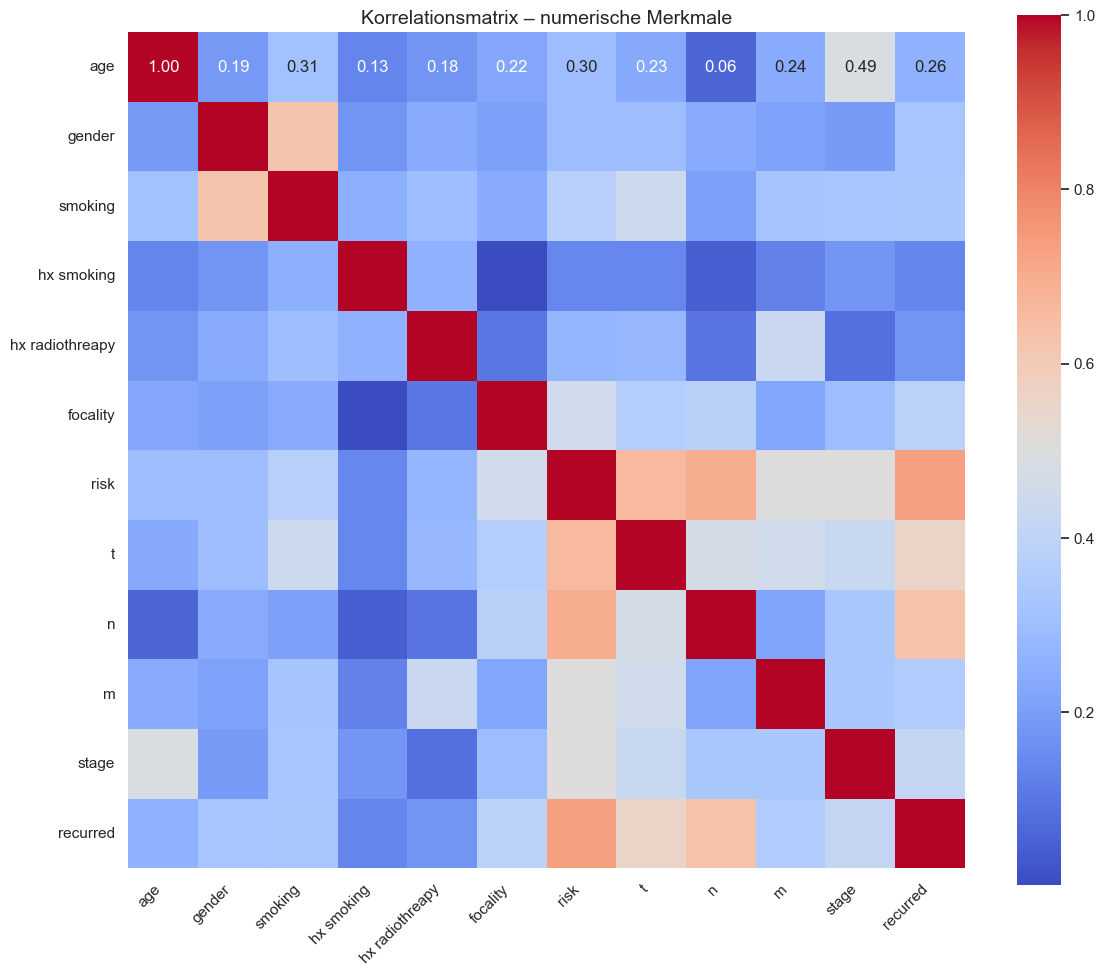

In [771]:
# Nur numerische Spalten
df_numeric = df.select_dtypes(include=[np.number])

# Korrelationsmatrix berechnen
korrelationsmatrix = df_numeric.corr()

# Heatmap erstellen
plt.figure(figsize=(12, 10))
sns.heatmap(korrelationsmatrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Korrelationsmatrix – numerische Merkmale", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


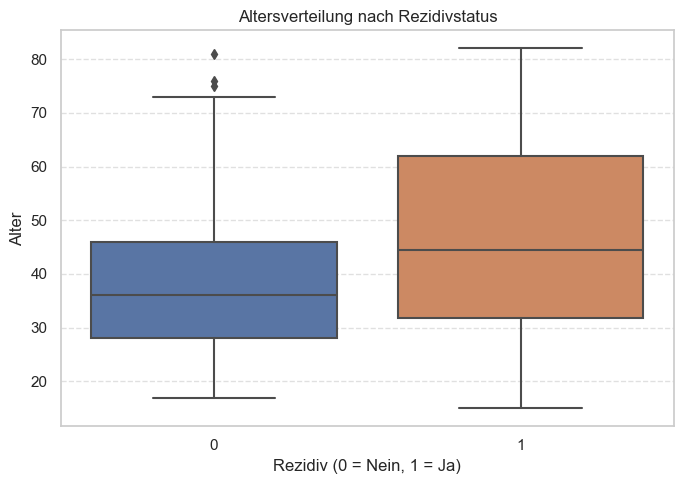

In [772]:
# Verteilung des Alters nach Rezidiv
plt.figure(figsize=(7, 5))
sns.boxplot(x='recurred', y='age', data=df)
plt.title('Altersverteilung nach Rezidivstatus')
plt.xlabel('Rezidiv (0 = Nein, 1 = Ja)')
plt.ylabel('Alter')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


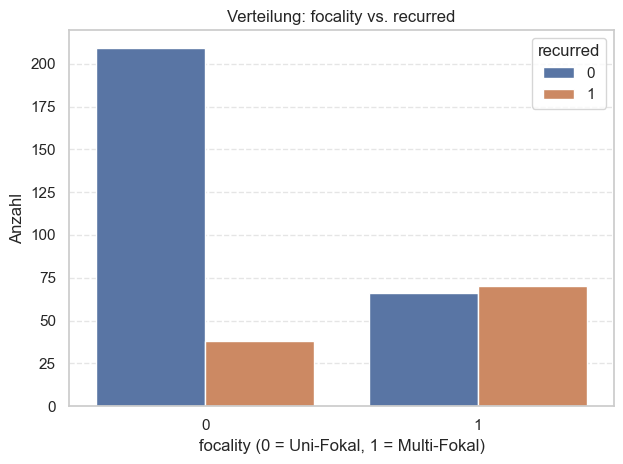

In [773]:
sns.countplot(x='focality', hue=df['recurred'].astype(str), data=df)
plt.title('Verteilung: focality vs. recurred')
plt.xlabel('focality (0 = Uni-Fokal, 1 = Multi-Fokal)')
plt.ylabel('Anzahl')
plt.legend(title='recurred')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


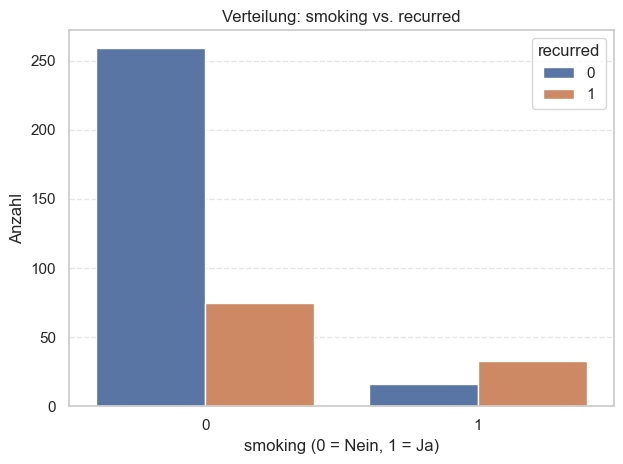

In [774]:
sns.countplot(x='smoking', hue=df['recurred'].astype(str), data=df)
plt.title('Verteilung: smoking vs. recurred')
plt.xlabel('smoking (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl')
plt.legend(title='recurred')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


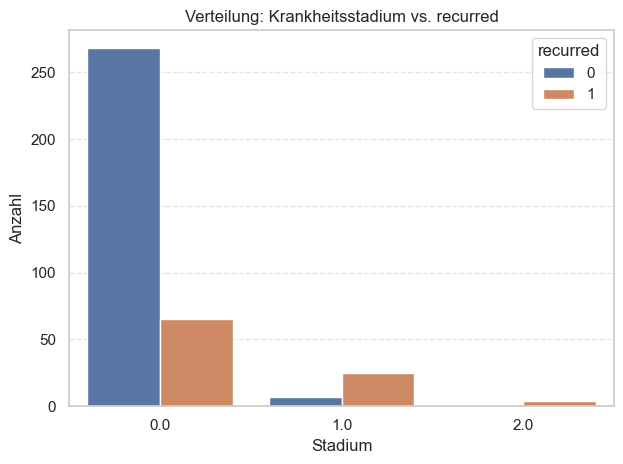

In [775]:
sns.countplot(x='stage', hue=df['recurred'].astype(str), data=df)
plt.title('Verteilung: Krankheitsstadium vs. recurred')
plt.xlabel('Stadium')
plt.ylabel('Anzahl')
plt.legend(title='recurred')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 3 Modellvorbereitung : Feature-Matrix & Zielvariable erstellen

In [777]:
# Zielvariable
y = df['recurred']

# Alle anderen Spalten außer der Zielvariable als Features
X = df.drop('recurred', axis=1)

# Aufteilen in Trainings- und Testdaten (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Kontrolle der Dimensionen
print("Trainingsmenge:", X_train.shape)
print("Testmenge:", X_test.shape)


Trainingsmenge: (306, 30)
Testmenge: (77, 30)


In [778]:
# Für numerische Spalten: mit Mittelwert füllen
imputer = SimpleImputer(strategy='most_frequent')  # 'mean' de olabilir
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [779]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [780]:
# Modell initialisieren und trainieren
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_log = log_model.predict(X_test)

# Bewertung
print("Genauigkeit (Accuracy) – Logistische Regression:", accuracy_score(y_test, y_pred_log))
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_log, target_names=["Kein Rezidiv", "Rezidiv"]))

print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred_log))


Genauigkeit (Accuracy) – Logistische Regression: 0.961038961038961

Klassifikationsbericht:
              precision    recall  f1-score   support

Kein Rezidiv       0.95      1.00      0.97        55
     Rezidiv       1.00      0.86      0.93        22

    accuracy                           0.96        77
   macro avg       0.97      0.93      0.95        77
weighted avg       0.96      0.96      0.96        77


Konfusionsmatrix:
[[55  0]
 [ 3 19]]


In [781]:
# Modell initialisieren und trainieren
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_tree = tree_model.predict(X_test)

# Bewertung
print("Genauigkeit (Accuracy) – Entscheidungsbaum:", accuracy_score(y_test, y_pred_tree))
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_tree, target_names=["Kein Rezidiv", "Rezidiv"]))

print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred_tree))


Genauigkeit (Accuracy) – Entscheidungsbaum: 0.948051948051948

Klassifikationsbericht:
              precision    recall  f1-score   support

Kein Rezidiv       0.95      0.98      0.96        55
     Rezidiv       0.95      0.86      0.90        22

    accuracy                           0.95        77
   macro avg       0.95      0.92      0.93        77
weighted avg       0.95      0.95      0.95        77


Konfusionsmatrix:
[[54  1]
 [ 3 19]]


In [782]:
# Parameter-Raster definieren
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Modell initialisieren
tree = DecisionTreeClassifier(random_state=42)

# GridSearch mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy')

# Suche starten
grid_search.fit(X_train, y_train)

# Bestes Modell und Parameter ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit (CV):", grid_search.best_score_)


Beste Parameter: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Beste Genauigkeit (CV): 0.9445267054468534


In [783]:
# Optimiertes Modell mit besten Parametern
best_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)

# Training
best_tree.fit(X_train, y_train)

# Vorhersage auf Testdaten
y_pred_best_tree = best_tree.predict(X_test)

# Bewertung
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Genauigkeit (Accuracy) – Optimierter Entscheidungsbaum:", accuracy_score(y_test, y_pred_best_tree))
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_best_tree, target_names=["Kein Rezidiv", "Rezidiv"]))
print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred_best_tree))


Genauigkeit (Accuracy) – Optimierter Entscheidungsbaum: 0.935064935064935

Klassifikationsbericht:
              precision    recall  f1-score   support

Kein Rezidiv       0.96      0.95      0.95        55
     Rezidiv       0.87      0.91      0.89        22

    accuracy                           0.94        77
   macro avg       0.92      0.93      0.92        77
weighted avg       0.94      0.94      0.94        77


Konfusionsmatrix:
[[52  3]
 [ 2 20]]


# 4 Random Forest Modellierung

In [785]:
# Random Forest initialisieren und trainieren
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_rf = rf_model.predict(X_test)

# Bewertung
print("Genauigkeit (Accuracy) – Random Forest:", accuracy_score(y_test, y_pred_rf))
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_rf, target_names=["Kein Rezidiv", "Rezidiv"]))
print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred_rf))


Genauigkeit (Accuracy) – Random Forest: 0.961038961038961

Klassifikationsbericht:
              precision    recall  f1-score   support

Kein Rezidiv       0.95      1.00      0.97        55
     Rezidiv       1.00      0.86      0.93        22

    accuracy                           0.96        77
   macro avg       0.97      0.93      0.95        77
weighted avg       0.96      0.96      0.96        77


Konfusionsmatrix:
[[55  0]
 [ 3 19]]


In [786]:
# Parameter-Raster definieren
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Modell initialisieren
rf = RandomForestClassifier(random_state=42)

# GridSearch mit 5-facher Kreuzvalidierung
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                              cv=5, n_jobs=-1, scoring='accuracy')

# Suche starten
grid_search_rf.fit(X_train, y_train)

# Bestes Modell und Parameter ausgeben
print("Beste Parameter RF:", grid_search_rf.best_params_)
print("Beste Genauigkeit RF (CV):", grid_search_rf.best_score_)


Beste Parameter RF: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Beste Genauigkeit RF (CV): 0.9673188789000529


In [787]:
# Bestes Modell mit GridSearch Parametern
best_rf = RandomForestClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Training
best_rf.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_best_rf = best_rf.predict(X_test)

# Bewertung
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Genauigkeit (Accuracy) – Optimierter Random Forest:", accuracy_score(y_test, y_pred_best_rf))
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_best_rf, target_names=["Kein Rezidiv", "Rezidiv"]))
print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred_best_rf))


Genauigkeit (Accuracy) – Optimierter Random Forest: 0.961038961038961

Klassifikationsbericht:
              precision    recall  f1-score   support

Kein Rezidiv       0.95      1.00      0.97        55
     Rezidiv       1.00      0.86      0.93        22

    accuracy                           0.96        77
   macro avg       0.97      0.93      0.95        77
weighted avg       0.96      0.96      0.96        77


Konfusionsmatrix:
[[55  0]
 [ 3 19]]


                           Feature  Importance
18  response_structural incomplete    0.321798
16              response_excellent    0.130975
6                             risk    0.119577
13                   adenopathy_no    0.073225
8                                n    0.060741
0                              age    0.059057
17          response_indeterminate    0.050137
7                                t    0.026979
5                         focality    0.017363
1                           gender    0.017011


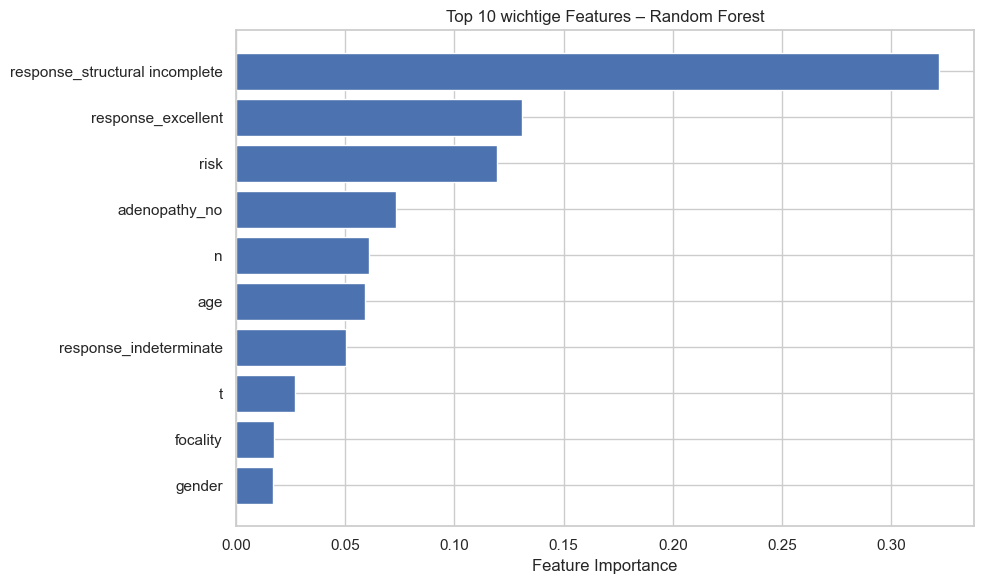

In [788]:
# Feature Importance aus dem besten Random Forest Modell
feature_importances = best_rf.feature_importances_

# Feature Namen
feature_names = X.columns

# DataFrame für bessere Visualisierung
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Wichtigste Features anzeigen
print(feat_imp_df.head(10))

# Visualisierung
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:10][::-1], feat_imp_df['Importance'][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 wichtige Features – Random Forest')
plt.tight_layout()
plt.show()


# 5 Modellvergleich verschiedener Algorithmen
 

Logistische Regression: Genauigkeit = 0.9610
Entscheidungsbaum: Genauigkeit = 0.9351
Random Forest: Genauigkeit = 0.9610


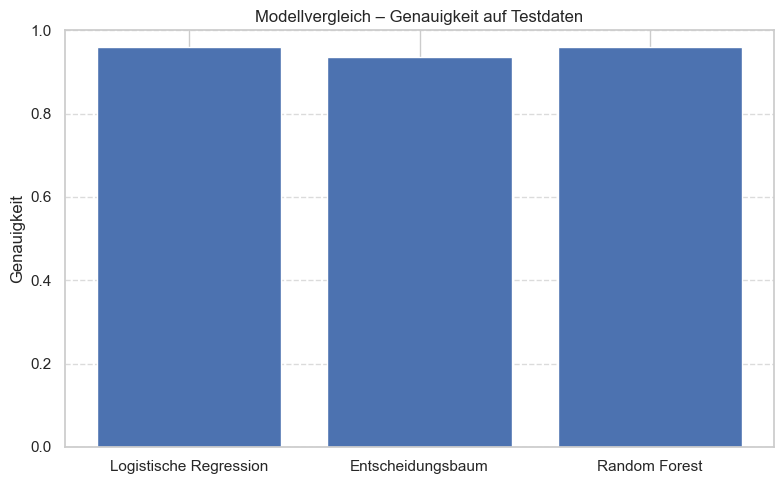

In [790]:
# Modelle und ihre Vorhersagen sammeln
modelle = {
    'Logistische Regression': y_pred_log,
    'Entscheidungsbaum': y_pred_best_tree,
    'Random Forest': y_pred_best_rf
}

# Genauigkeiten berechnen
genauigkeiten = {name: accuracy_score(y_test, preds) for name, preds in modelle.items()}

# Ergebnisse ausgeben
for modell, acc in genauigkeiten.items():
    print(f"{modell}: Genauigkeit = {acc:.4f}")

# Barplot zur Visualisierung
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(genauigkeiten.keys(), genauigkeiten.values())
plt.ylabel('Genauigkeit')
plt.title('Modellvergleich – Genauigkeit auf Testdaten')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


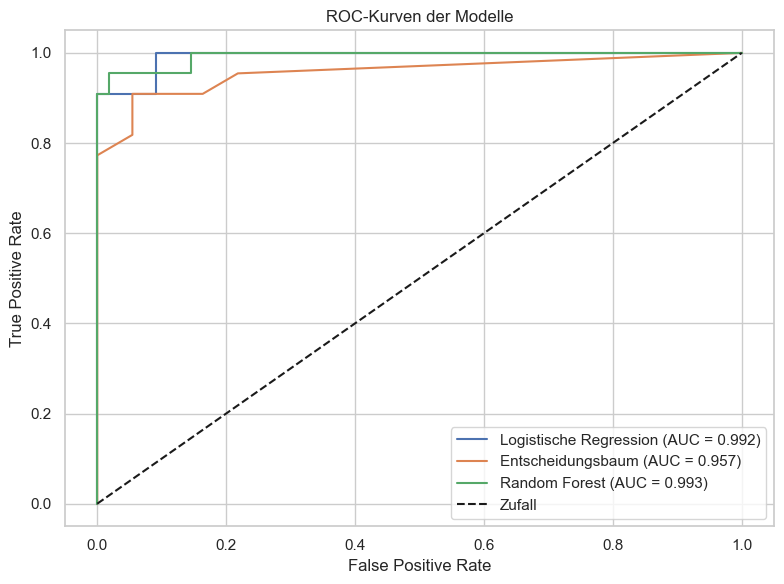

In [791]:
# predict_proba Vermutungen
modelle = {
    'Logistische Regression': log_model,
    'Entscheidungsbaum': best_tree,
    'Random Forest': best_rf
}

plt.figure(figsize=(8, 6))

for name, model in modelle.items():
    # Test_Predict_Pozitif
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Zufall')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven der Modelle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [792]:
# Bestes Random Forest Modell speichern
model_filename = 'best_random_forest_model.pkl'
joblib.dump(best_rf, model_filename)
print(f"Modell wurde gespeichert unter: {model_filename}")

# Modell laden (Test)
loaded_model = joblib.load(model_filename)
# Testvorhersage mit geladenem Modell
test_pred = loaded_model.predict(X_test)
print(f"Testvorhersage mit geladenem Modell - Accuracy: {accuracy_score(y_test, test_pred):.4f}")


Modell wurde gespeichert unter: best_random_forest_model.pkl
Testvorhersage mit geladenem Modell - Accuracy: 0.9610


# 6 Fazit und Ausblick

In [794]:
# 6.1 Fazit und Ausblick

## Fazit

# - Wir konnten die Rezidivrate bei differenziertem Schilddrüsenkrebs mit hoher Genauigkeit anhand verschiedener klinischer und demografischer Merkmale vorhersagen.  
# - Random Forest und logistische Regression zeigten die besten Modellleistungen.  
# - Die Analyse der Feature-Importance zeigte, dass insbesondere die Behandlungsantwort (Response) und das Risikoprofil (Risk) entscheidende Einflussgrößen sind.  
# - Fehlende Werte wurden durch geeignete Imputation behandelt, was zur Stabilität der Modelle beitrug.  
# - Die Ergebnisse eignen sich gut für den Einsatz in klinischen Entscheidungshilfesystemen.

## Ausblick

# - Erweiterung des Modells mit größeren und aktuelleren Datensätzen  
# - Einsatz weiterer Methoden, z.B. Deep Learning  
# - Validierung des Modells in realen klinischen Umgebungen  
# - Integration zusätzlicher Datenquellen, z.B. genetische Informationen  
# - Entwicklung benutzerfreundlicher Anwendungen für die klinische Praxis


In [795]:
# 6.2 Diskussion und Limitationen

## Diskussion

# - Unsere Modelle zeigen vielversprechende Ergebnisse zur Vorhersage von Rezidiven bei differenziertem Schilddrüsenkrebs.  
# - Besonders die hohe Genauigkeit und AUC-Werte unterstreichen die Leistungsfähigkeit der eingesetzten Algorithmen.  
# - Die Analyse der Feature-Importance liefert wertvolle Einblicke in die wichtigsten Einflussfaktoren, was für klinische Entscheidungsprozesse hilfreich ist.  
# - Dennoch sollten die Ergebnisse mit Vorsicht interpretiert werden, da einige Variablen möglicherweise korreliert sind und multikollineare Effekte auftreten können.

## Limitationen

# - Die Datengrundlage ist auf einen spezifischen Patientenkreis beschränkt, was die Generalisierbarkeit der Modelle einschränken kann.  
# - Fehlende Werte und mögliche Messfehler könnten die Modellleistung beeinflussen, trotz der durchgeführten Imputationen.  
# - Die Modelle wurden retrospektiv trainiert; prospektive Validierungen in realen klinischen Settings sind notwendig.  
# - Potenzielle wichtige Biomarker oder genetische Faktoren wurden nicht berücksichtigt und sollten in zukünftigen Studien integriert werden.  

## Fazit

# Trotz dieser Einschränkungen bietet die vorliegende Arbeit eine solide Basis für den Einsatz von Machine Learning in der klinischen Vorhersage von Schilddrüsenkrebsrezidiven und zeigt das Potenzial für weitere Verbesserungen.


# Extras

In [797]:
anzahl_duplikate = df.duplicated().sum()
print(f"\nAnzahl Duplikate: {anzahl_duplikate}")

# Falls vorhanden, entfernen
df = df.drop_duplicates()



Anzahl Duplikate: 19


In [798]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

print("\nSpaltennamen nach Bereinigung:")
print(df.columns.tolist())



Spaltennamen nach Bereinigung:
['age', 'gender', 'smoking', 'hx_smoking', 'hx_radiothreapy', 'focality', 'risk', 't', 'n', 'm', 'stage', 'recurred', 'adenopathy_extensive', 'adenopathy_left', 'adenopathy_no', 'adenopathy_posterior', 'adenopathy_right', 'response_excellent', 'response_indeterminate', 'response_structural_incomplete', 'pathology_hurthel_cell', 'pathology_micropapillary', 'pathology_papillary', 'thyroid_function_clinical_hypothyroidism', 'thyroid_function_euthyroid', 'thyroid_function_subclinical_hyperthyroidism', 'thyroid_function_subclinical_hypothyroidism', 'physical_examination_multinodular_goiter', 'physical_examination_normal', 'physical_examination_single_nodular_goiter-left', 'physical_examination_single_nodular_goiter-right']


In [799]:
print(df['recurred'].value_counts(dropna=False))


recurred
0    256
1    108
Name: count, dtype: int64


In [800]:
# 'recurred' Spalte prüfen und 'recurred_binary' als 0/1 erstellen
if 'recurred' in df.columns:
    df['recurred_binary'] = df['recurred'].map({'No': 0, 'Yes': 1})
    print("✔ Die Spalte 'recurred_binary' wurde erfolgreich erstellt.")
else:
    print(" Die Spalte 'recurred' ist im DataFrame nicht vorhanden.")


✔ Die Spalte 'recurred_binary' wurde erfolgreich erstellt.


In [801]:
print(df['recurred'].unique())


[0 1]


In [802]:
df.rename(columns={'recurred': 'recurred_binary'}, inplace=True)


In [803]:
print(df.columns.tolist())


['age', 'gender', 'smoking', 'hx_smoking', 'hx_radiothreapy', 'focality', 'risk', 't', 'n', 'm', 'stage', 'recurred_binary', 'adenopathy_extensive', 'adenopathy_left', 'adenopathy_no', 'adenopathy_posterior', 'adenopathy_right', 'response_excellent', 'response_indeterminate', 'response_structural_incomplete', 'pathology_hurthel_cell', 'pathology_micropapillary', 'pathology_papillary', 'thyroid_function_clinical_hypothyroidism', 'thyroid_function_euthyroid', 'thyroid_function_subclinical_hyperthyroidism', 'thyroid_function_subclinical_hypothyroidism', 'physical_examination_multinodular_goiter', 'physical_examination_normal', 'physical_examination_single_nodular_goiter-left', 'physical_examination_single_nodular_goiter-right', 'recurred_binary']


In [804]:
# Nur eindeutige Spaltennamen behalten (z. B. erste Instanz von jedem Namen)
df = df.loc[:, ~df.columns.duplicated()]


In [805]:
print(df.columns.tolist())


['age', 'gender', 'smoking', 'hx_smoking', 'hx_radiothreapy', 'focality', 'risk', 't', 'n', 'm', 'stage', 'recurred_binary', 'adenopathy_extensive', 'adenopathy_left', 'adenopathy_no', 'adenopathy_posterior', 'adenopathy_right', 'response_excellent', 'response_indeterminate', 'response_structural_incomplete', 'pathology_hurthel_cell', 'pathology_micropapillary', 'pathology_papillary', 'thyroid_function_clinical_hypothyroidism', 'thyroid_function_euthyroid', 'thyroid_function_subclinical_hyperthyroidism', 'thyroid_function_subclinical_hypothyroidism', 'physical_examination_multinodular_goiter', 'physical_examination_normal', 'physical_examination_single_nodular_goiter-left', 'physical_examination_single_nodular_goiter-right']


In [806]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 382
Data columns (total 31 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   age                                               364 non-null    int64  
 1   gender                                            364 non-null    int64  
 2   smoking                                           364 non-null    int64  
 3   hx_smoking                                        364 non-null    int64  
 4   hx_radiothreapy                                   364 non-null    int64  
 5   focality                                          364 non-null    int64  
 6   risk                                              364 non-null    int64  
 7   t                                                 252 non-null    float64
 8   n                                                 364 non-null    int64  
 9   m                         

In [807]:
print(df.describe(include=[np.number]))


             age      gender     smoking  hx_smoking  hx_radiothreapy  \
count  364.00000  364.000000  364.000000  364.000000       364.000000   
mean    41.25000    0.195055    0.134615    0.076923         0.019231   
std     15.31436    0.396788    0.341782    0.266836         0.137524   
min     15.00000    0.000000    0.000000    0.000000         0.000000   
25%     30.00000    0.000000    0.000000    0.000000         0.000000   
50%     38.00000    0.000000    0.000000    0.000000         0.000000   
75%     52.00000    0.000000    0.000000    0.000000         0.000000   
max     82.00000    1.000000    1.000000    1.000000         1.000000   

         focality        risk           t           n           m       stage  \
count  364.000000  364.000000  252.000000  364.000000  364.000000  350.000000   
mean     0.373626    0.456044    1.730159    0.571429    0.049451    0.114286   
std      0.484432    0.651966    1.193693    0.870614    0.217105    0.352757   
min      0.000000 

Korrelationsmatrix:


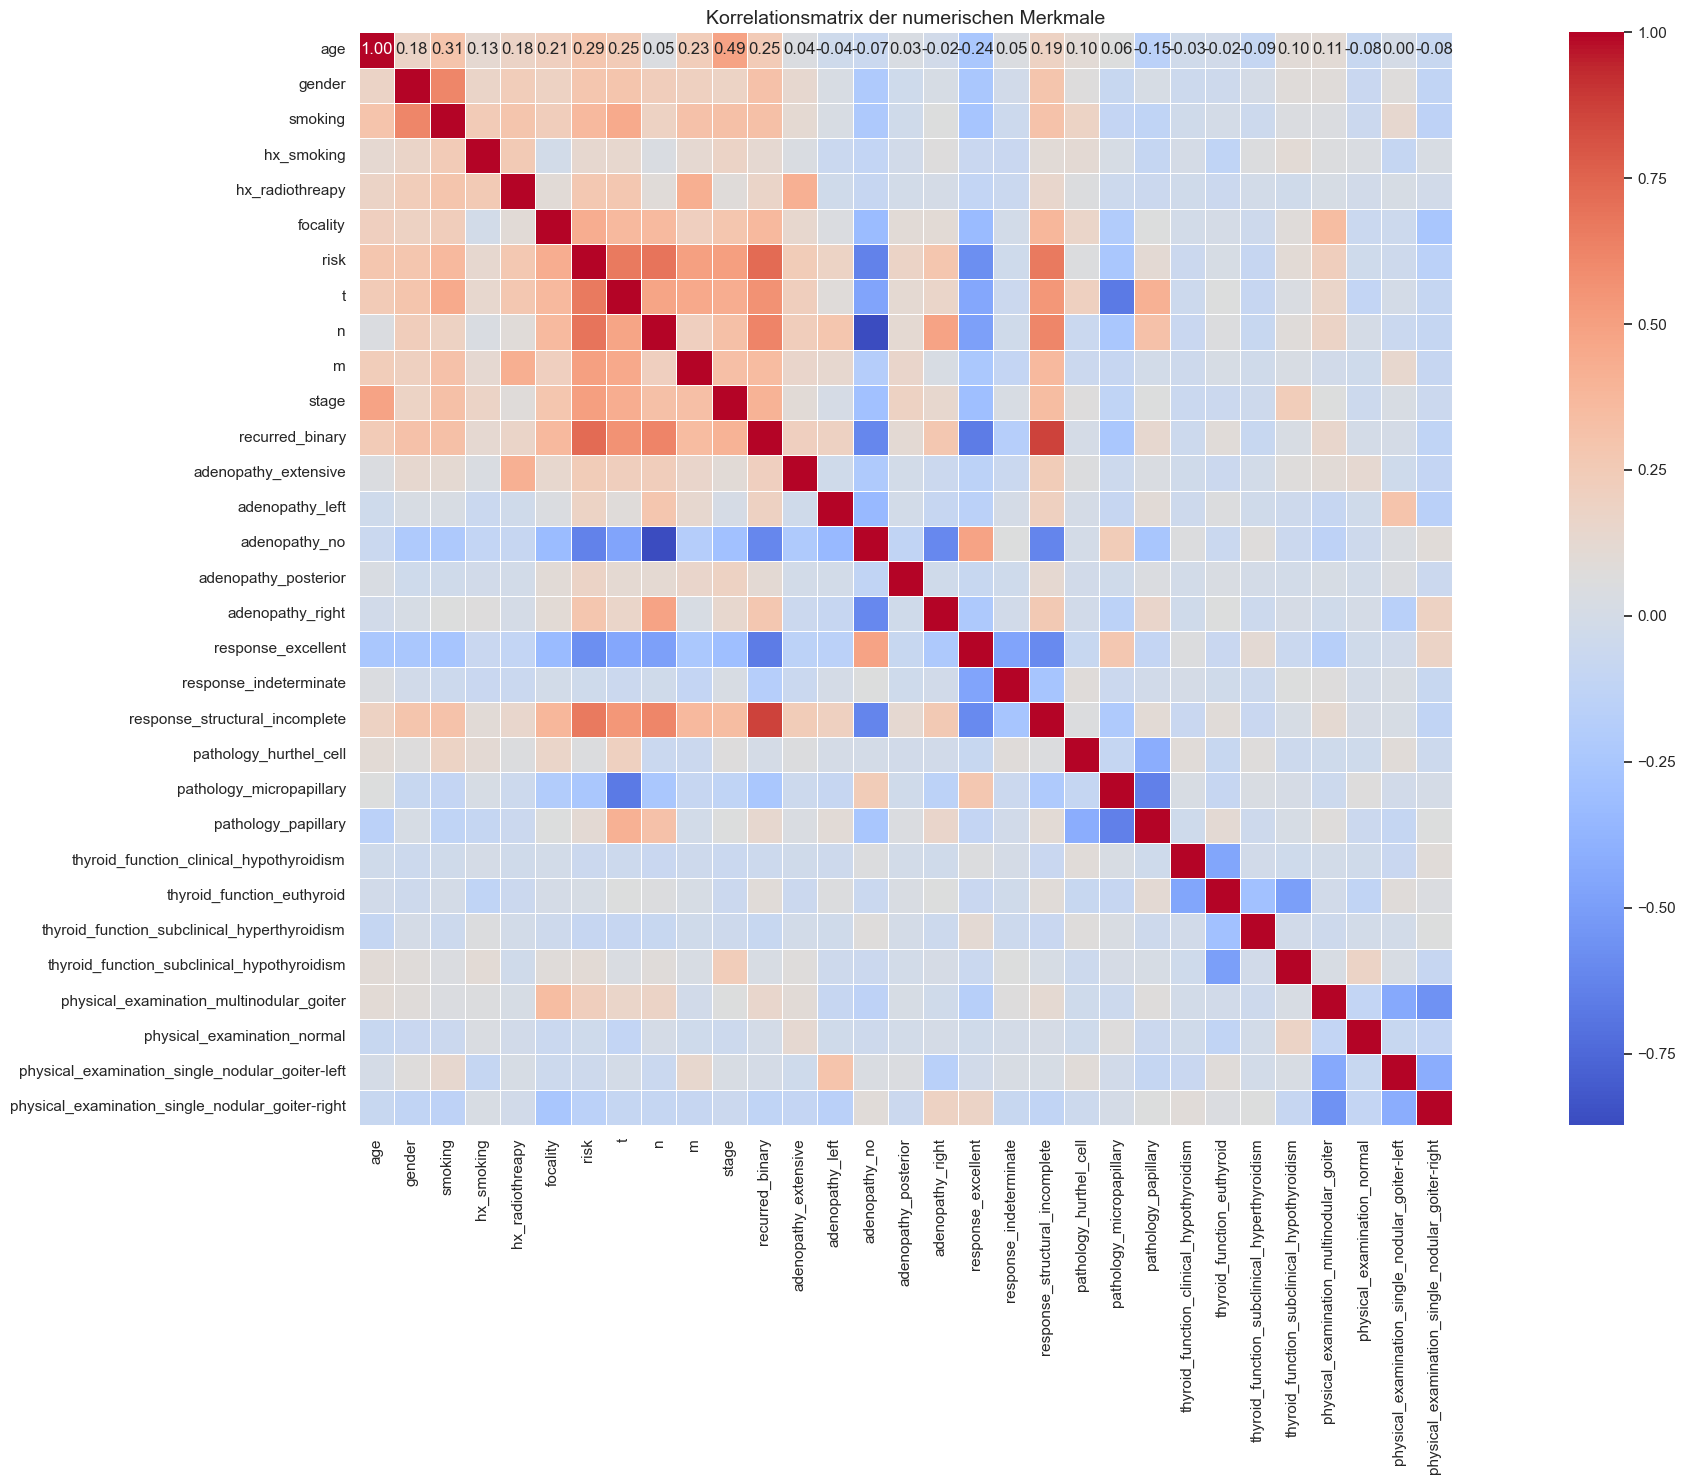

In [808]:
# Optional: neuen Analyse-DataFrame erzeugen
df_model = df.copy()  # oder gezielt bereinigen / auswählen

# Korrelationsmatrix berechnen (nur numerische Daten)
print("Korrelationsmatrix:")
corr_matrix = df_model.corr(numeric_only=True)

# Heatmap anzeigen
plt.figure(figsize=(24, 15))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
    square=True, linewidths=0.5
)
plt.title("Korrelationsmatrix der numerischen Merkmale", fontsize=14)
plt.tight_layout()
plt.show()


In [809]:
#  Stil
sns.set(style="whitegrid")
plt.style.use("ggplot")

# ===================================================
#  Vorverarbeitung
# ===================================================

# Spaltennamen standardisieren
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Zielvariable vorbereiten (falls nötig)
if 'recurred_binary' not in df.columns and 'recurred' in df.columns:
    df['recurred'] = df['recurred'].astype(str).str.strip().str.lower()
    df['recurred_binary'] = df['recurred'].map({'no': 0, 'yes': 1})

# Nur gültige Zielwerte behalten
df = df.dropna(subset=['recurred_binary'])

# Hilfsspalten ausschließen
drop_cols = ['recurred', 'recurred_clean', 'recurred_binary_str']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Fehlende Werte behandeln
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

# Kategorische Variablen kodieren
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category').cat.codes

# Merkmale und Ziel definieren
X = df.drop(columns=['recurred_binary'])
y = df['recurred_binary']


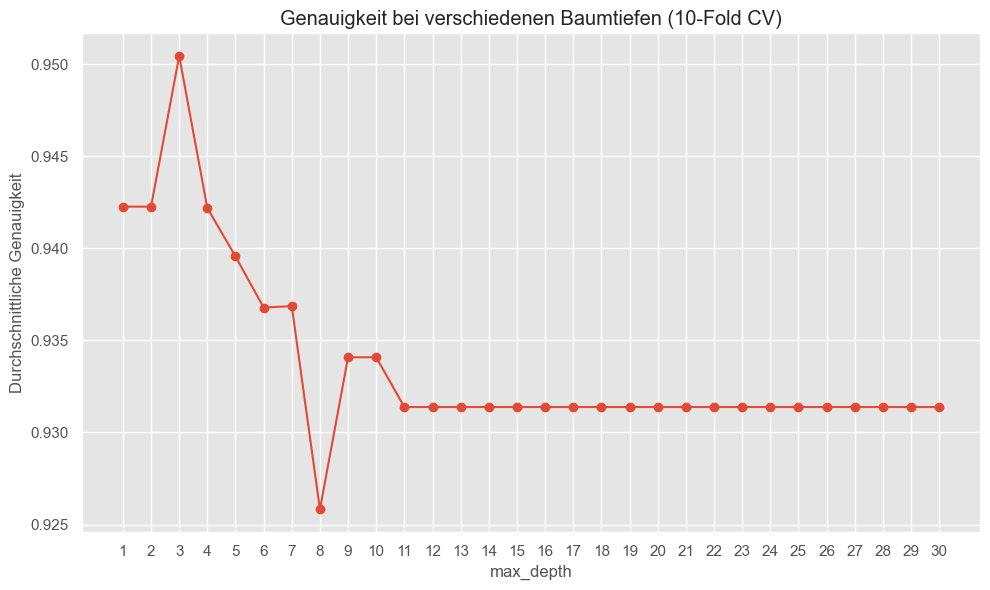

In [810]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
depth_range = range(1, X.shape[1] + 1)

for depth in depth_range:
    fold_accuracy = []
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = clf.fit(X_train, y_train)
        accuracy = model.score(X_valid, y_valid)
        fold_accuracy.append(accuracy)

    accuracies.append(np.mean(fold_accuracy))

#  Plot der Genauigkeit
plt.figure(figsize=(10, 6))
plt.plot(depth_range, accuracies, marker='o')
plt.title("Genauigkeit bei verschiedenen Baumtiefen (10-Fold CV)")
plt.xlabel("max_depth")
plt.ylabel("Durchschnittliche Genauigkeit")
plt.xticks(depth_range)
plt.grid(True)
plt.tight_layout()
plt.show()


Verfügbare Spalten in df_cleaned:
['age', 'gender', 'smoking', 'hx_smoking', 'hx_radiothreapy', 'focality', 'risk', 't', 'n', 'm', 'stage', 'recurred_binary', 'adenopathy_extensive', 'adenopathy_left', 'adenopathy_no', 'adenopathy_posterior', 'adenopathy_right', 'response_excellent', 'response_indeterminate', 'response_structural_incomplete', 'pathology_hurthel_cell', 'pathology_micropapillary', 'pathology_papillary', 'thyroid_function_clinical_hypothyroidism', 'thyroid_function_euthyroid', 'thyroid_function_subclinical_hyperthyroidism', 'thyroid_function_subclinical_hypothyroidism', 'physical_examination_multinodular_goiter', 'physical_examination_normal', 'physical_examination_single_nodular_goiter-left', 'physical_examination_single_nodular_goiter-right']

Modell: Logistische Regression
Accuracy: 0.836
Confusion Matrix:
 [[45  6]
 [ 6 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        51
           1

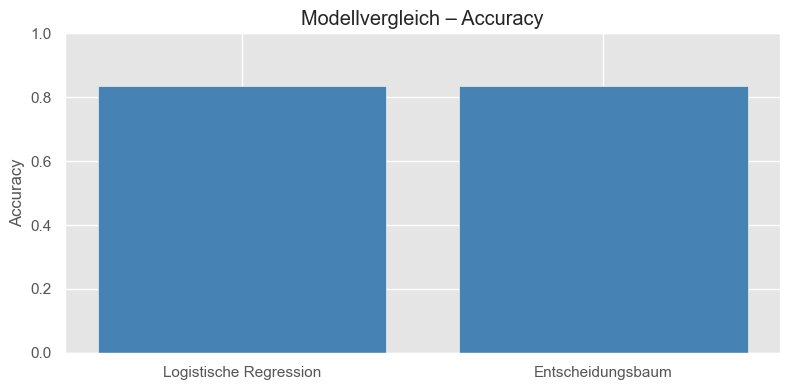

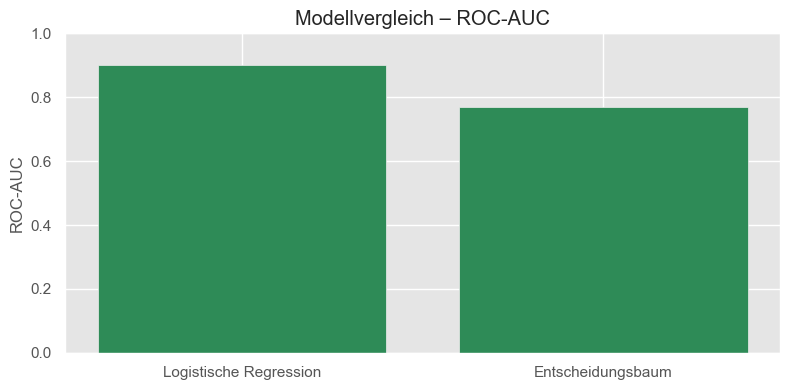

In [811]:
# Datenvorbereitung
df_cleaned = df.copy()

target_col = "recurred_binary"

# Spaltenliste anzeigen zur Kontrolle
print("Verfügbare Spalten in df_cleaned:")
print(df_cleaned.columns.tolist())

# Prüfung, ob Zielvariable existiert
if target_col not in df_cleaned.columns:
    raise ValueError(f"Zielvariable '{target_col}' wurde nicht in den Spalten gefunden.")

X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

# Nur numerische Features verwenden
X = X.select_dtypes(include=["int64", "float64"])

# Aufteilen in Trainings- und Testdaten (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fehlende Werte mit Median imputieren
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Skalierung der imputierten Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Modelle definieren
models = {
    "Logistische Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Entscheidungsbaum": DecisionTreeClassifier(random_state=42)
}

accuracy_scores = {}
roc_auc_scores = {}

# Modelle trainieren und bewerten
for name, model in models.items():
    print(f"\nModell: {name}")

    if name == "Logistische Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_imputed, y_train)
        y_pred = model.predict(X_test_imputed)
        y_proba = model.predict_proba(X_test_imputed)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = acc
    print(f"Accuracy: {acc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    if len(y.unique()) == 2:
        auc = roc_auc_score(y_test, y_proba)
        roc_auc_scores[name] = auc
        print(f"🏁 ROC-AUC Score: {auc:.3f}")
    else:
        roc_auc_scores[name] = None

# Accuracy Barplot
plt.figure(figsize=(8, 4))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='steelblue')
plt.title("Modellvergleich – Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ROC-AUC Barplot (wenn möglich)
if all(v is not None for v in roc_auc_scores.values()):
    plt.figure(figsize=(8, 4))
    plt.bar(roc_auc_scores.keys(), roc_auc_scores.values(), color='seagreen')
    plt.title("Modellvergleich – ROC-AUC")
    plt.ylabel("ROC-AUC")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print("ROC-AUC konnte nicht für alle Modelle berechnet werden.")



Wichtigste Merkmale – Logistische Regression (nach Betrag der Koeffizienten):
risk: 1.4194
t: 0.7755
n: 0.6782
m: 0.4260
gender: 0.3803
age: 0.3174
stage: 0.2350
hx smoking: 0.2023
focality: 0.1044
hx radiothreapy: -0.0613


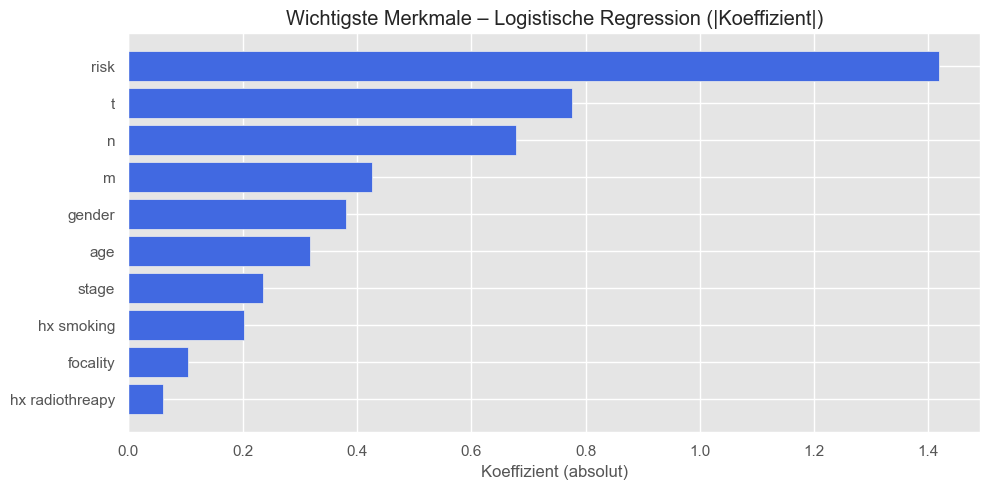

In [812]:
# Optional: Wichtigste Merkmale – Logistische Regression
lr_model = models["Logistische Regression"]
lr_coefs = lr_model.coef_[0]
coef_sorted_idx = np.argsort(np.abs(lr_coefs))[::-1]

print("\nWichtigste Merkmale – Logistische Regression (nach Betrag der Koeffizienten):")
for idx in coef_sorted_idx[:10]:
    print(f"{feature_names[idx]}: {lr_coefs[idx]:.4f}")

plt.figure(figsize=(10, 5))
plt.barh([feature_names[i] for i in coef_sorted_idx[:10]],
         np.abs(lr_coefs[coef_sorted_idx[:10]]), color='royalblue')
plt.gca().invert_yaxis()
plt.title("Wichtigste Merkmale – Logistische Regression (|Koeffizient|)")
plt.xlabel("Koeffizient (absolut)")
plt.tight_layout()
plt.show()


In [813]:
# Spaltennamen vereinheitlichen
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Zielvariable vorbereiten
if 'recurred' in df.columns:
    df['recurred'] = df['recurred'].astype(str).str.strip().str.lower()
    df['recurred_binary'] = df['recurred'].map({'yes': 1, 'no': 0})

# Fehlende Zielwerte entfernen
df = df.dropna(subset=['recurred_binary'])

# Kategorische Variablen kodieren
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category').cat.codes

# Fehlende numerische Werte mit Median füllen
for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Features & Zielvariable
X = df.drop(columns=['recurred', 'recurred_binary'], errors='ignore')
y = df['recurred_binary']

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [814]:
# Modellübersicht
models = {
    "Entscheidungsbaum": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


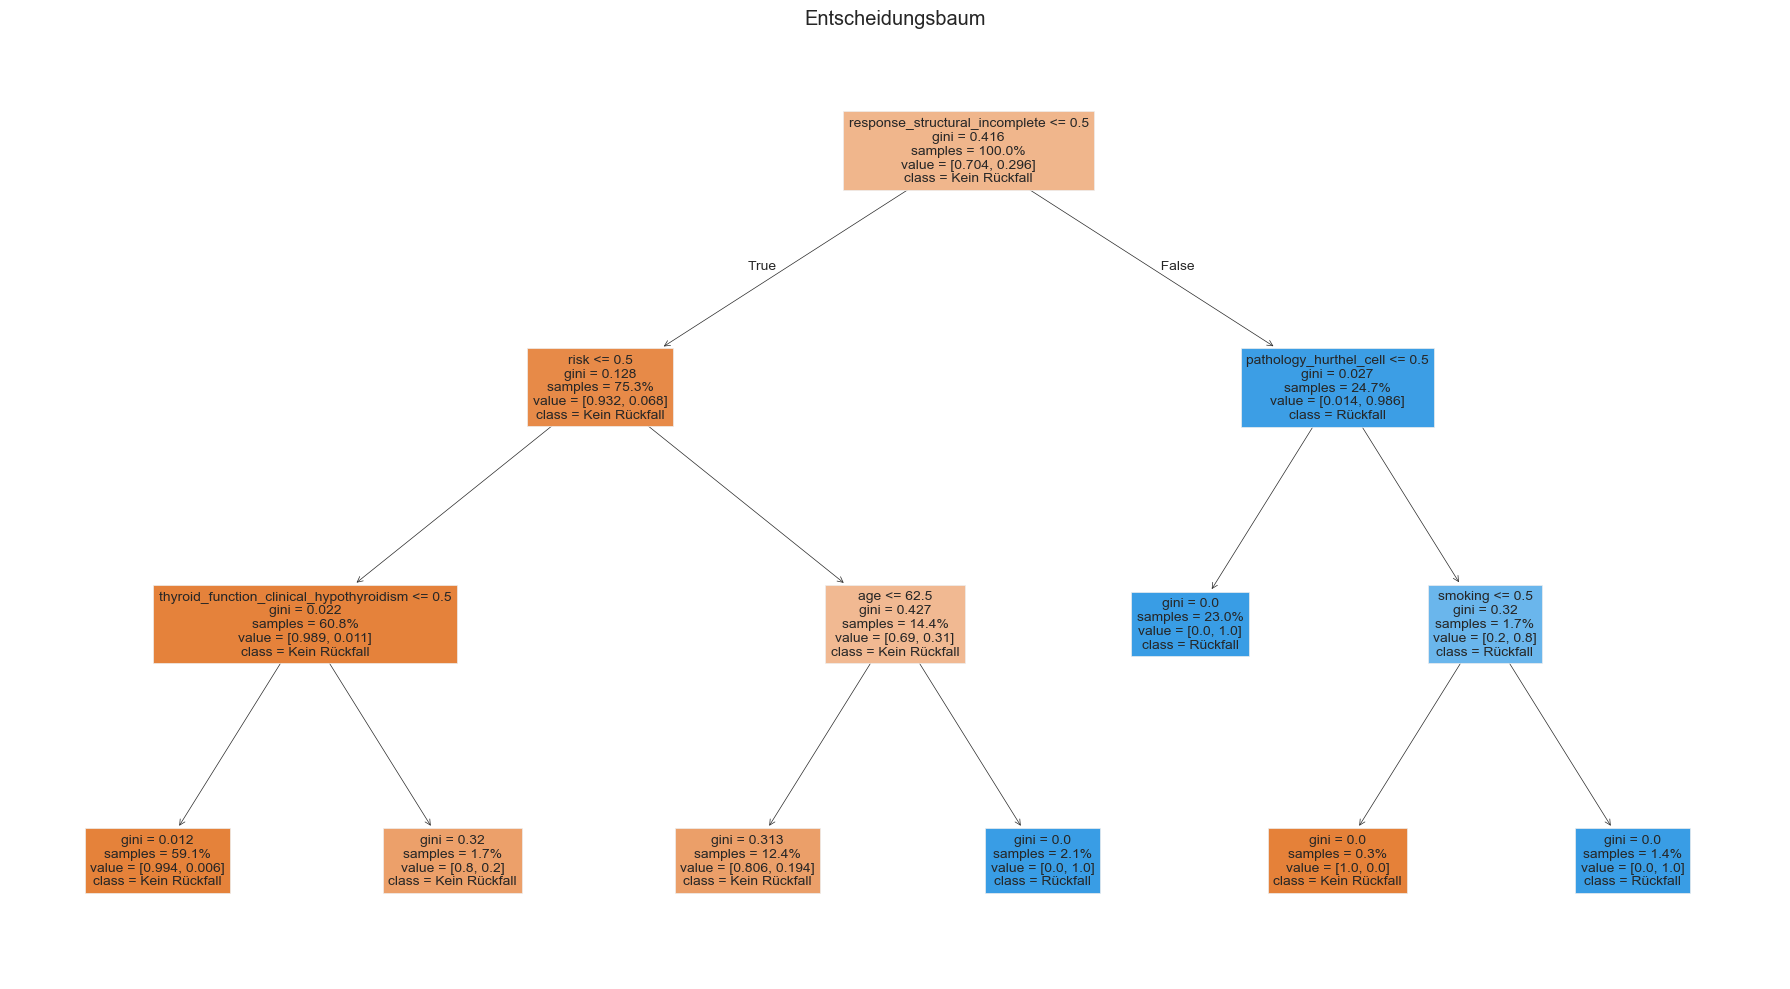

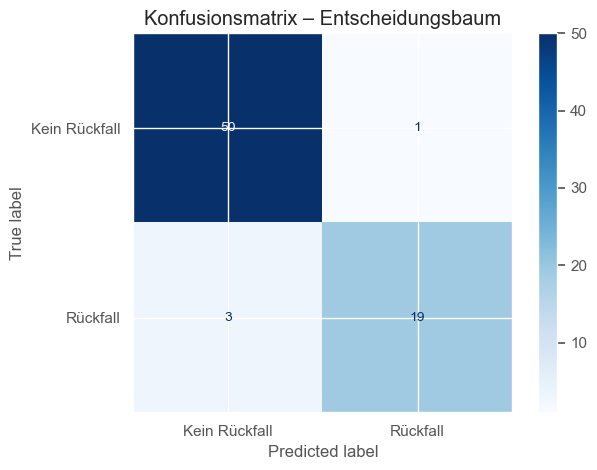

Accuracy:  0.95
Precision: 0.95
Recall:    0.86
F1-Score:  0.90

Klassifikationsbericht:
               precision    recall  f1-score   support

Kein Rückfall       0.94      0.98      0.96        51
     Rückfall       0.95      0.86      0.90        22

     accuracy                           0.95        73
    macro avg       0.95      0.92      0.93        73
 weighted avg       0.95      0.95      0.94        73



In [815]:
modell = DecisionTreeClassifier(max_depth=3, random_state=42)
modell.fit(X_train, y_train)
y_pred = modell.predict(X_test)

# Baum-Visualisierung
plt.figure(figsize=(18, 10))
plot_tree(modell, filled=True, feature_names=X.columns,
          class_names=["Kein Rückfall", "Rückfall"], proportion=True, fontsize=10)
plt.title("Entscheidungsbaum")
plt.tight_layout()
plt.show()

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Rückfall", "Rückfall"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Konfusionsmatrix – Entscheidungsbaum")
plt.tight_layout()
plt.show()

# Metriken
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall:    {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.2f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred, target_names=["Kein Rückfall", "Rückfall"]))


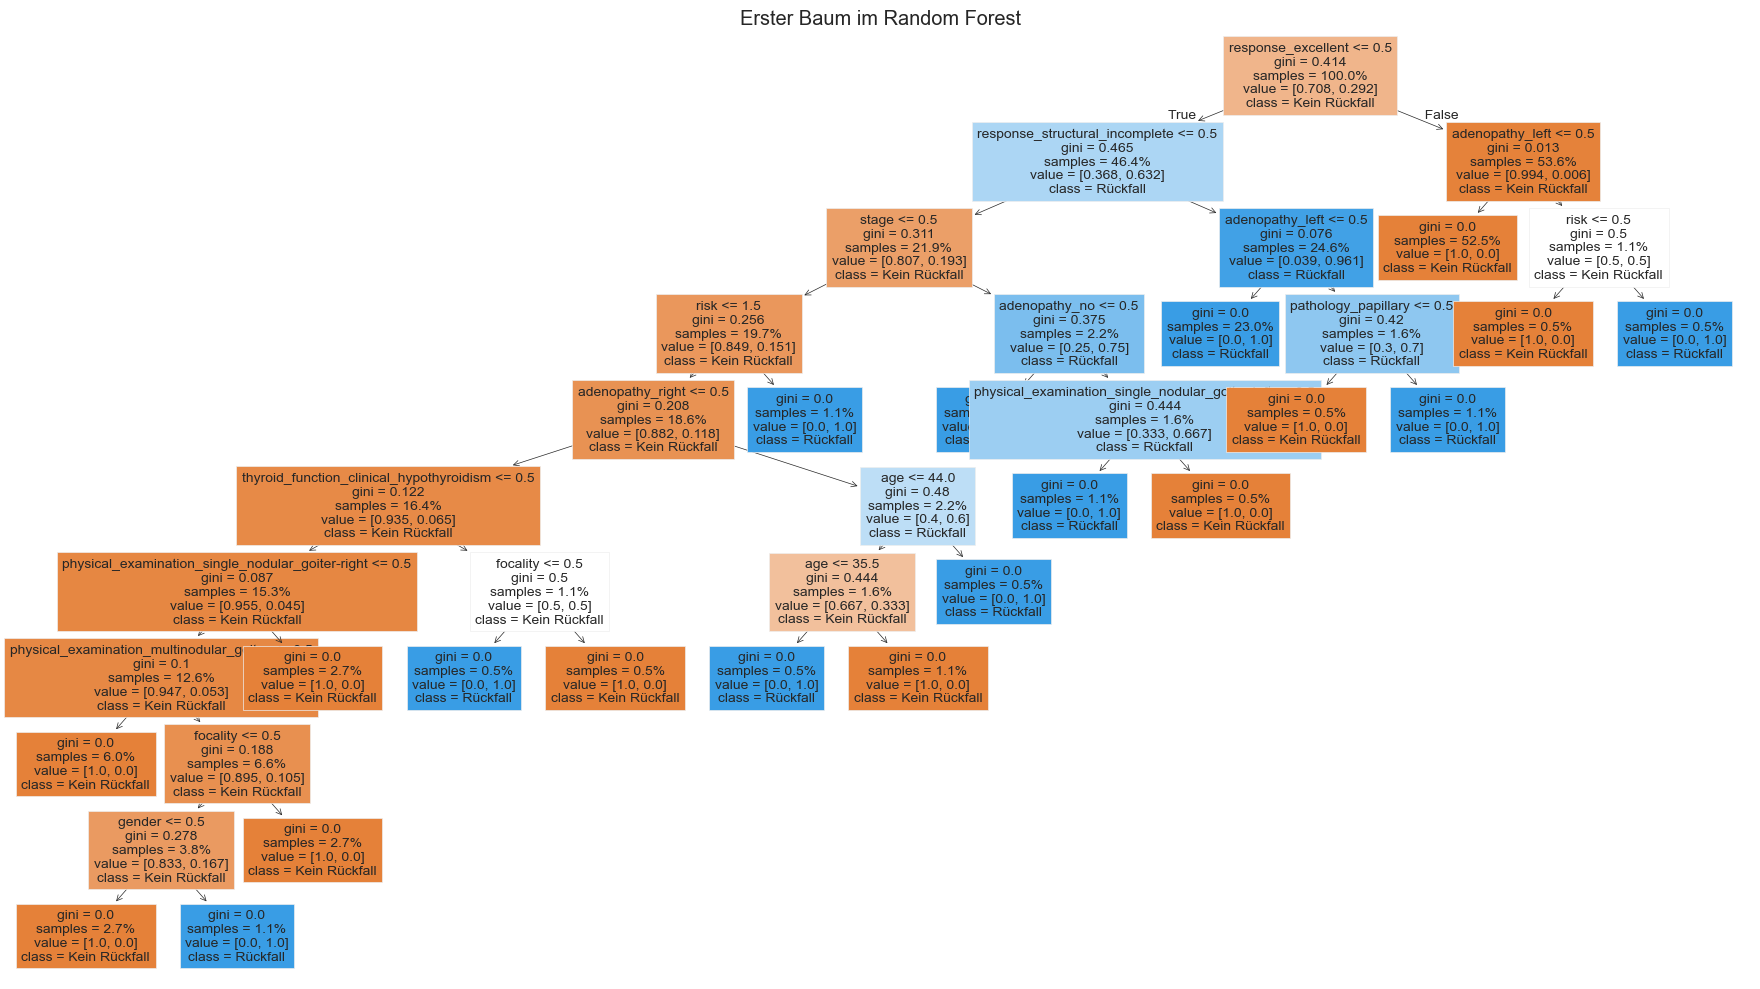

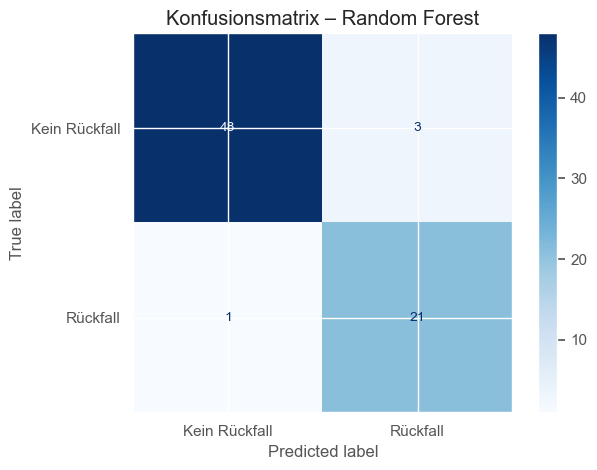

Accuracy:  0.95
Precision: 0.88
Recall:    0.95
F1-Score:  0.91

Klassifikationsbericht:
               precision    recall  f1-score   support

Kein Rückfall       0.98      0.94      0.96        51
     Rückfall       0.88      0.95      0.91        22

     accuracy                           0.95        73
    macro avg       0.93      0.95      0.94        73
 weighted avg       0.95      0.95      0.95        73



In [816]:
modell = RandomForestClassifier(n_estimators=50, random_state=42)
modell.fit(X_train, y_train)
y_pred = modell.predict(X_test)

# Visualisierung des ersten Baums
plt.figure(figsize=(18, 10))
plot_tree(modell.estimators_[0], filled=True, feature_names=X.columns,
          class_names=["Kein Rückfall", "Rückfall"], proportion=True, fontsize=10)
plt.title("Erster Baum im Random Forest")
plt.tight_layout()
plt.show()

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Rückfall", "Rückfall"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Konfusionsmatrix – Random Forest")
plt.tight_layout()
plt.show()

# Metriken
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall:    {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.2f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred, target_names=["Kein Rückfall", "Rückfall"]))


<Figure size 1800x1000 with 0 Axes>

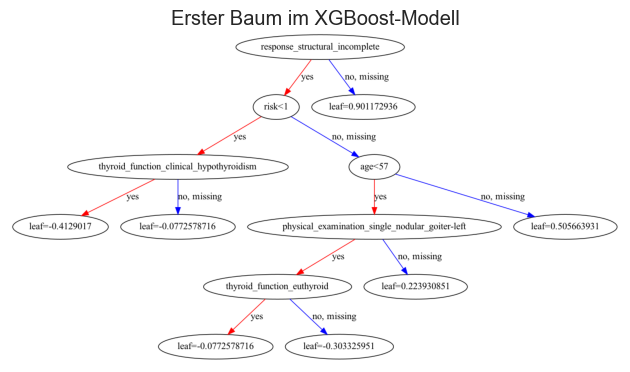

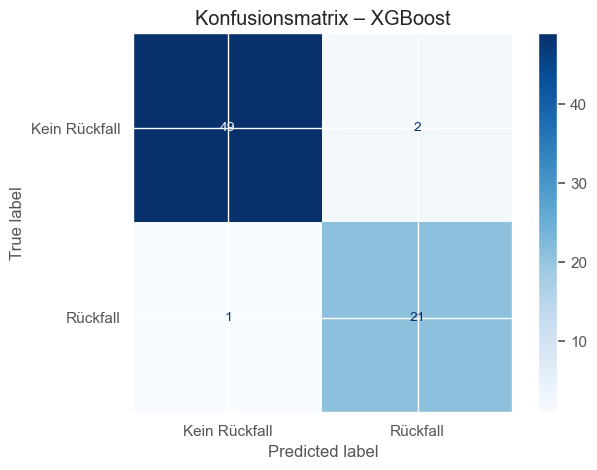

Accuracy:  0.96
Precision: 0.91
Recall:    0.95
F1-Score:  0.93

Klassifikationsbericht:
               precision    recall  f1-score   support

Kein Rückfall       0.98      0.96      0.97        51
     Rückfall       0.91      0.95      0.93        22

     accuracy                           0.96        73
    macro avg       0.95      0.96      0.95        73
 weighted avg       0.96      0.96      0.96        73



In [817]:
modell = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modell.fit(X_train, y_train)
y_pred = modell.predict(X_test)

# XGBoost Baum-Visualisierung
plt.figure(figsize=(18, 10))
xgb_plot_tree(modell, num_trees=0)
plt.title("Erster Baum im XGBoost-Modell")
plt.tight_layout()
plt.show()

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Rückfall", "Rückfall"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Konfusionsmatrix – XGBoost")
plt.tight_layout()
plt.show()

# Metriken
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall:    {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.2f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred, target_names=["Kein Rückfall", "Rückfall"]))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


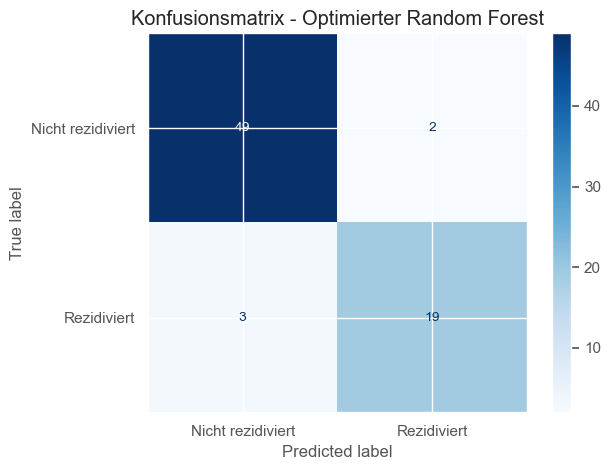

 Klassifikationsbericht - Random Forest:
                    precision    recall  f1-score   support

Nicht rezidiviert       0.94      0.96      0.95        51
      Rezidiviert       0.90      0.86      0.88        22

         accuracy                           0.93        73
        macro avg       0.92      0.91      0.92        73
     weighted avg       0.93      0.93      0.93        73



In [818]:
#  Parametergitter (ohne random_state!)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#  Random Forest Basis-Modell mit fixem random_state
rf_model = RandomForestClassifier(random_state=1)

#  Grid Search CV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

#  Modell trainieren
grid_search_rf.fit(X_train, y_train)

#  Bestes Modell extrahieren
best_rf = grid_search_rf.best_estimator_

#  Predict now
y_pred_best_rf = best_rf.predict(X_test)

#  Konfusionsmatrix anzeigen
conf_matrix_rf = confusion_matrix(y_test, y_pred_best_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['Nicht rezidiviert', 'Rezidiviert'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix - Optimierter Random Forest')
plt.tight_layout()
plt.show()

#  Klassifikationsbericht
report_rf = classification_report(y_test, y_pred_best_rf, target_names=['Nicht rezidiviert', 'Rezidiviert'])
print(" Klassifikationsbericht - Random Forest:\n", report_rf)


In [819]:
# Parameter-Raster für Entscheidungsbaum
param_grid_tree = {
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

baum = DecisionTreeClassifier(random_state=42)
grid_tree = GridSearchCV(baum, param_grid_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_tree.fit(X_train, y_train)

print(" Bester Entscheidungsbaum:")
print(" Beste Parameter:", grid_tree.best_params_)
print(" Beste Accuracy (CV):", grid_tree.best_score_)

# Bester Baum anwenden und evaluieren
best_baum = grid_tree.best_estimator_
y_pred_best_baum = best_baum.predict(X_test)
print(" Test-Accuracy (bestes Baum-Modell):", accuracy_score(y_test, y_pred_best_baum))


 Bester Entscheidungsbaum:
 Beste Parameter: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
 Beste Accuracy (CV): 0.9589129164231442
 Test-Accuracy (bestes Baum-Modell): 0.9452054794520548


In [820]:
# Parameter-Raster für Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(" Bester Random Forest:")
print(" Beste Parameter:", grid_rf.best_params_)
print(" Beste Accuracy (CV):", grid_rf.best_score_)

# Bester Random Forest anwenden und evaluieren
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print(" Test-Accuracy (bestes RF-Modell):", accuracy_score(y_test, y_pred_best_rf))


 Bester Random Forest:
 Beste Parameter: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
 Beste Accuracy (CV): 0.9657510227936879
 Test-Accuracy (bestes RF-Modell): 0.9452054794520548



 Klassifikationsbericht für: Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        51
           1       0.95      0.86      0.90        22

    accuracy                           0.95        73
   macro avg       0.95      0.92      0.93        73
weighted avg       0.95      0.95      0.94        73


 Klassifikationsbericht für: Random Forest
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        51
           1       0.88      0.95      0.91        22

    accuracy                           0.95        73
   macro avg       0.93      0.95      0.94        73
weighted avg       0.95      0.95      0.95        73


 Klassifikationsbericht für: XGBoost
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        51
           1       0.91      0.95      0.93        22

    accuracy                           0.96        73
  

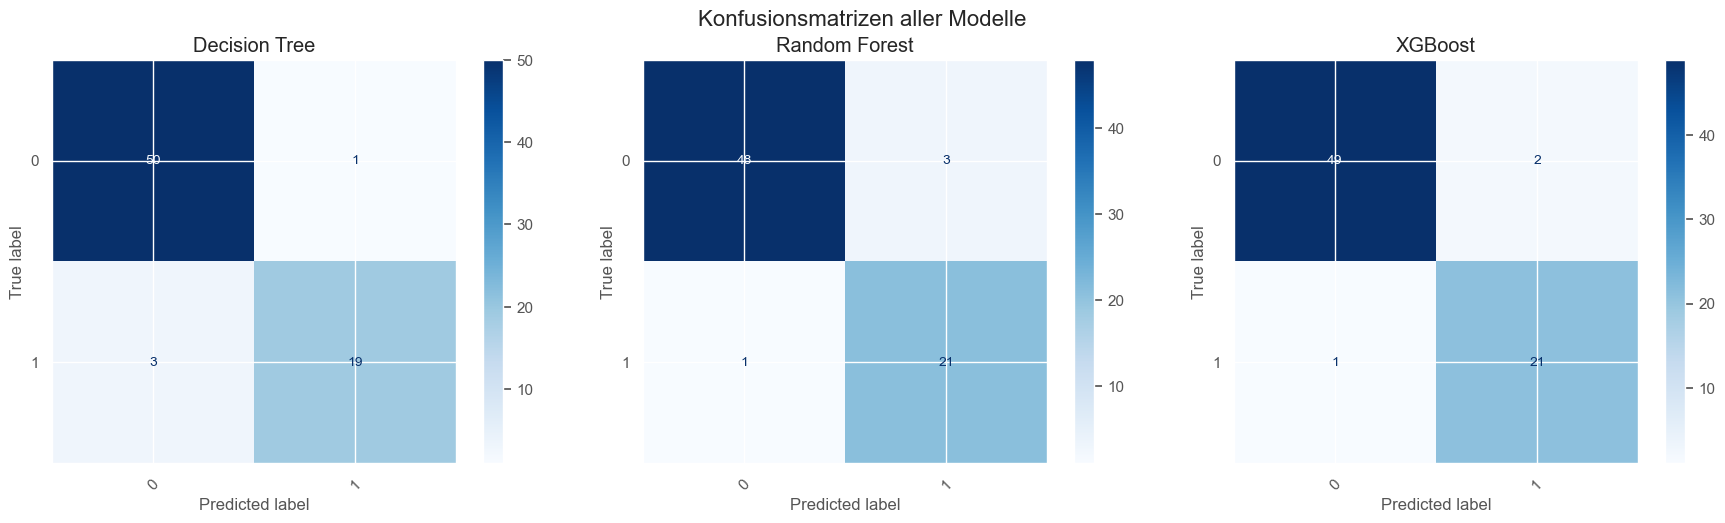


 Zusammenfassung der Metriken:


,Genauigkeit,Präzision,Recall,F1-Score
Decision Tree,0.9452,0.9454,0.9452,0.9444
Random Forest,0.9452,0.9481,0.9452,0.9458
XGBoost,0.9589,0.9598,0.9589,0.9592


In [821]:
#  Modelle definieren
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

#  Dictionary zur Speicherung der Metriken
evaluation_results = {}

#  Modelle trainieren
for name, model in models.items():
    model.fit(X_train, y_train)

#  Konfusionsmatrizen vorbereiten (subplot)
fig, axs = plt.subplots(1, len(models), figsize=(6 * len(models), 5))

#  Modelle bewerten
for idx, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)

    #  Metriken berechnen
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    #  Ergebnisse speichern
    evaluation_results[model_name] = {
        'Genauigkeit': accuracy,
        'Präzision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    #  Klassifikationsbericht ausgeben
    print(f"\n Klassifikationsbericht für: {model_name}")
    print(classification_report(y_test, y_pred, zero_division=0))

    #  Konfusionsmatrix zeichnen
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axs[idx], cmap=plt.cm.Blues, xticks_rotation=45)
    axs[idx].set_title(model_name)

#  Alle Konfusionsmatrizen zusammen zeigen
plt.suptitle("Konfusionsmatrizen aller Modelle", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

#  Gesamtergebnisse als DataFrame anzeigen
print("\n Zusammenfassung der Metriken:")
df_ergebnisse = pd.DataFrame(evaluation_results).T.round(4)
display(df_ergebnisse)


In [822]:
#  Nur eindeutige Modelle sicherstellen (wichtig, wenn doppelte Keys existieren)
einzigartige_modelle = {name: modell for name, modell in models.items()}

#  Training vs. Test-Leistung prüfen
for name, modell in einzigartige_modelle.items():
    print(f"\n Bewertung für Modell: {name}")

    #  Vorhersage auf Trainingsdaten
    y_train_pred = modell.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    #  Vorhersage auf Testdaten
    y_test_pred = modell.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    #  Genauigkeiten anzeigen
    print(f"Trainingsgenauigkeit für {name}: {train_acc:.4f}")
    print(f"Testgenauigkeit für {name}:     {test_acc:.4f}")

    #  Unterschied analysieren
    diff = train_acc - test_acc
    if diff > 0.10:
        print(" Hinweis: Mögliches Overfitting!")
    elif diff < -0.05:
        print(" Hinweis: Möglicherweise Underfitting!")
    else:
        print(" Modell hat eine gute Generalisierung.")



 Bewertung für Modell: Decision Tree
Trainingsgenauigkeit für Decision Tree: 0.9691
Testgenauigkeit für Decision Tree:     0.9452
 Modell hat eine gute Generalisierung.

 Bewertung für Modell: Random Forest
Trainingsgenauigkeit für Random Forest: 1.0000
Testgenauigkeit für Random Forest:     0.9452
 Modell hat eine gute Generalisierung.

 Bewertung für Modell: XGBoost
Trainingsgenauigkeit für XGBoost: 1.0000
Testgenauigkeit für XGBoost:     0.9589
 Modell hat eine gute Generalisierung.


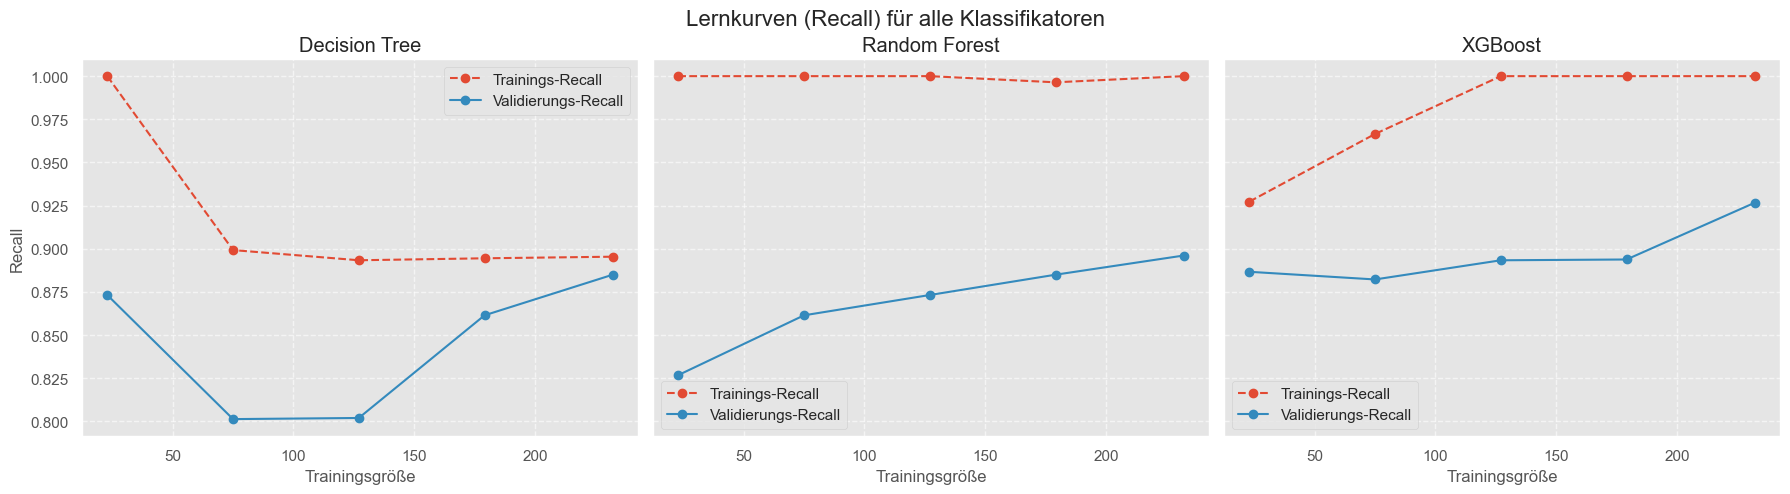

In [823]:
# Modellanzahl ermitteln
anzahl_modelle = len(models)
fig, axes = plt.subplots(1, anzahl_modelle, figsize=(6 * anzahl_modelle, 5), sharey=True)

if anzahl_modelle == 1:
    axes = [axes]  # Bei nur einem Modell, axes in Liste packen

for idx, (name, modell) in enumerate(models.items()):
    # Lernkurvendaten sammeln 
    train_sizes, train_scores, val_scores = learning_curve(
        modell, X_train, y_train,
        cv=5,
        scoring=make_scorer(recall_score, pos_label=1),
        train_sizes=np.linspace(0.1, 1.0, 5),
        random_state=42
    )

    # Durchschnitt berechnen
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    # Plot auf jeweilige Subplot-Achse
    ax = axes[idx]
    ax.plot(train_sizes, train_mean, 'o--', label="Trainings-Recall")
    ax.plot(train_sizes, val_mean, 'o-', label="Validierungs-Recall")
    ax.set_title(f"{name}")
    ax.set_xlabel("Trainingsgröße")
    if idx == 0:
        ax.set_ylabel("Recall")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

# Gesamttitel
plt.suptitle("Lernkurven (Recall) für alle Klassifikatoren", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [824]:
#  Stratified K-Fold vorbereiten
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ergebnisse speichern
recall_ergebnisse = {}

# Kreuzvalidierung durchführen
for name, modell in models.items():
    print(f"\n Stratifizierte Kreuzvalidierung für: {name}")

    # Cross-Validation auf Trainingsdaten (für Recall von Klasse 1)
    recall_scores = cross_val_score(
        modell, X_train, y_train,
        cv=stratified_kfold,
        scoring=make_scorer(recall_score, pos_label=1)
    )

    # Ergebnisse anzeigen
    print(f"Recall-Werte (CV) für {name}: {recall_scores}")
    print(f" Durchschnittlicher Recall (CV): {recall_scores.mean():.4f}")

    # Speichern
    recall_ergebnisse[name] = recall_scores.mean()

# Beste Modell basierend auf Recall identifizieren
bestes_modell = max(recall_ergebnisse, key=recall_ergebnisse.get)
bester_wert = recall_ergebnisse[bestes_modell]

# Zusammenfassung
print("\n Zusammenfassung der durchschnittlichen Recall-Werte:")
for modellname, recall_wert in recall_ergebnisse.items():
    print(f"{modellname}: {recall_wert:.4f}")

print(f"\n Das Modell mit dem höchsten durchschnittlichen Recall ist: **{bestes_modell}** mit einem Wert von **{bester_wert:.4f}**.")

# Optional: Wenn du willst, Markdown-Ausgabe in Jupyter:
from IPython.display import Markdown, display
display(Markdown(f"###  Bestes Modell basierend auf Recall: **{bestes_modell}** (`{bester_wert:.4f}`)"))



 Stratifizierte Kreuzvalidierung für: Decision Tree
Recall-Werte (CV) für Decision Tree: [0.94444444 1.         0.82352941 0.76470588 0.82352941]
 Durchschnittlicher Recall (CV): 0.8712

 Stratifizierte Kreuzvalidierung für: Random Forest
Recall-Werte (CV) für Random Forest: [0.88888889 1.         0.94117647 0.70588235 0.76470588]
 Durchschnittlicher Recall (CV): 0.8601

 Stratifizierte Kreuzvalidierung für: XGBoost
Recall-Werte (CV) für XGBoost: [0.94444444 1.         0.94117647 0.76470588 0.88235294]
 Durchschnittlicher Recall (CV): 0.9065

 Zusammenfassung der durchschnittlichen Recall-Werte:
Decision Tree: 0.8712
Random Forest: 0.8601
XGBoost: 0.9065

 Das Modell mit dem höchsten durchschnittlichen Recall ist: **XGBoost** mit einem Wert von **0.9065**.


###  Bestes Modell basierend auf Recall: **XGBoost** (`0.9065`)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


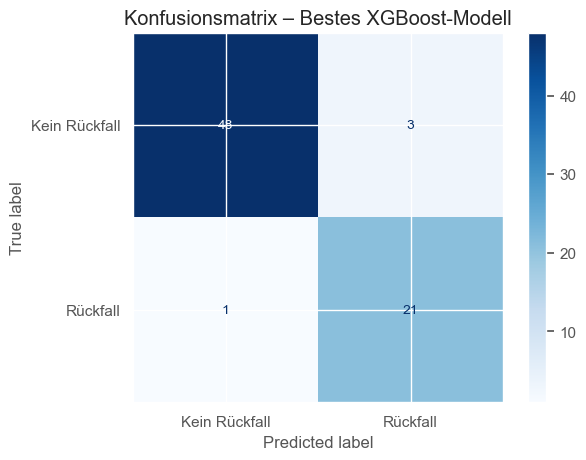

 Klassifikationsbericht für bestes XGBoost:

               precision    recall  f1-score   support

Kein Rückfall       0.98      0.94      0.96        51
     Rückfall       0.88      0.95      0.91        22

     accuracy                           0.95        73
    macro avg       0.93      0.95      0.94        73
 weighted avg       0.95      0.95      0.95        73



In [825]:
# Parametergitter für XGBoost (zum Beispiel)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# XGBoost-Modell
xgb_model = XGBClassifier()

# Neues GridSearch-Objekt speziell für XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Die GridSearch auf den Trainingsdaten ausführen
grid_search_xgb.fit(X_train, y_train)

# Bestes XGBoost-Modell speichern
best_xgb = grid_search_xgb.best_estimator_

# Vorhersagen mit dem besten Modell
y_pred_xgb = best_xgb.predict(X_test)

# Konfusionsmatrix anzeigen
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Kein Rückfall', 'Rückfall'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix – Bestes XGBoost-Modell')
plt.show()

# Klassifikationsbericht drucken
report_xgb = classification_report(
    y_test, y_pred_xgb,
    target_names=['Kein Rückfall', 'Rückfall']
)
print(" Klassifikationsbericht für bestes XGBoost:\n")
print(report_xgb)


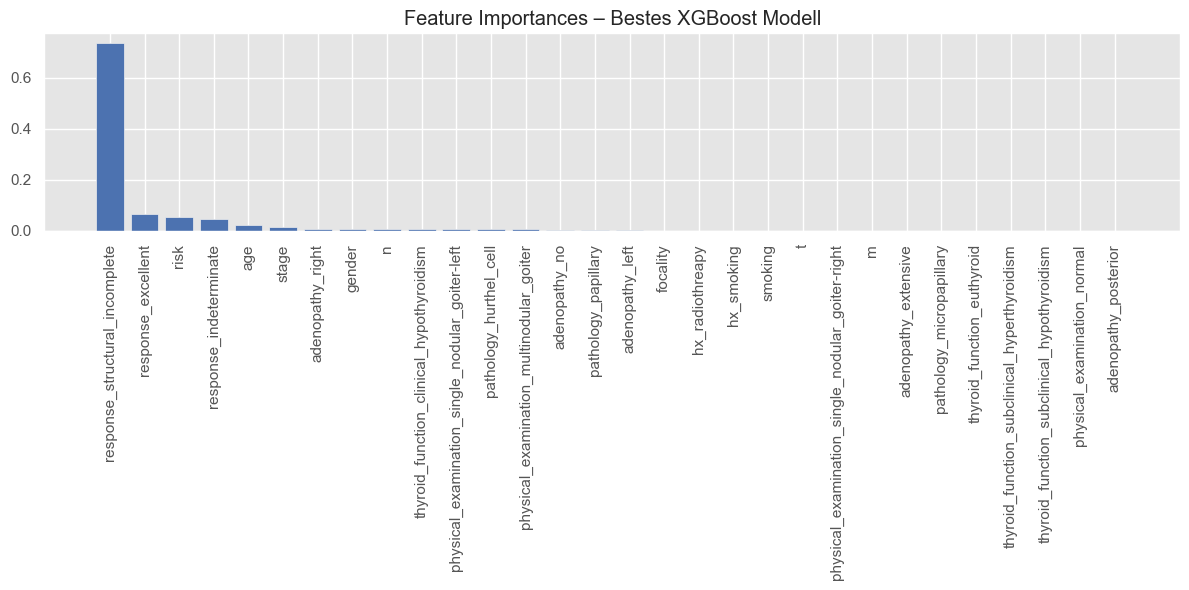

In [826]:
# Feature Importance – XGBoost
importances_xgb = best_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_names = X.columns

# Plot
plt.figure(figsize=(12, 6))
plt.title('Feature Importances – Bestes XGBoost Modell')
plt.bar(range(X.shape[1]), importances_xgb[indices_xgb], color="b", align="center")
plt.xticks(range(X.shape[1]), feature_names[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()

# Zur Bewertung der wichtigsten Einflussgrößen auf die Vorhersage des Rezidivs (Recurred) wurden die Feature-Importances der drei besten Modelle analysiert. Die Auswertung zeigt, dass sowohl beim Random Forest als auch beim XGBoost Modell die Variablen **T**, **N**, **Response** und **Stage** eine hohe Bedeutung besitzen. Diese Ergebnisse stimmen mit medizinischen Erkenntnissen über die Relevanz von Tumorstadien und Behandlungsantworten überein.

# Die Abbildung zeigt die Feature-Importances des besten XGBoost-Modells, das durch GridSearchCV optimiert wurde. 
# Besonders hervorzuheben sind Merkmale wie **T**, **N**, **Stage** und **Response**, die eine signifikante Rolle bei der 
# Vorhersage eines möglichen Rückfalls (Rezidiv) spielen. Die visuelle Gewichtung hilft bei der Interpretation und 
# zeigt, welche klinischen Faktoren für das Modell besonders entscheidend sind.


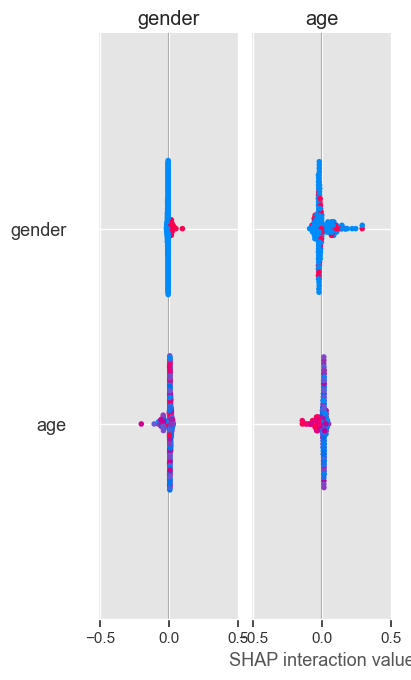

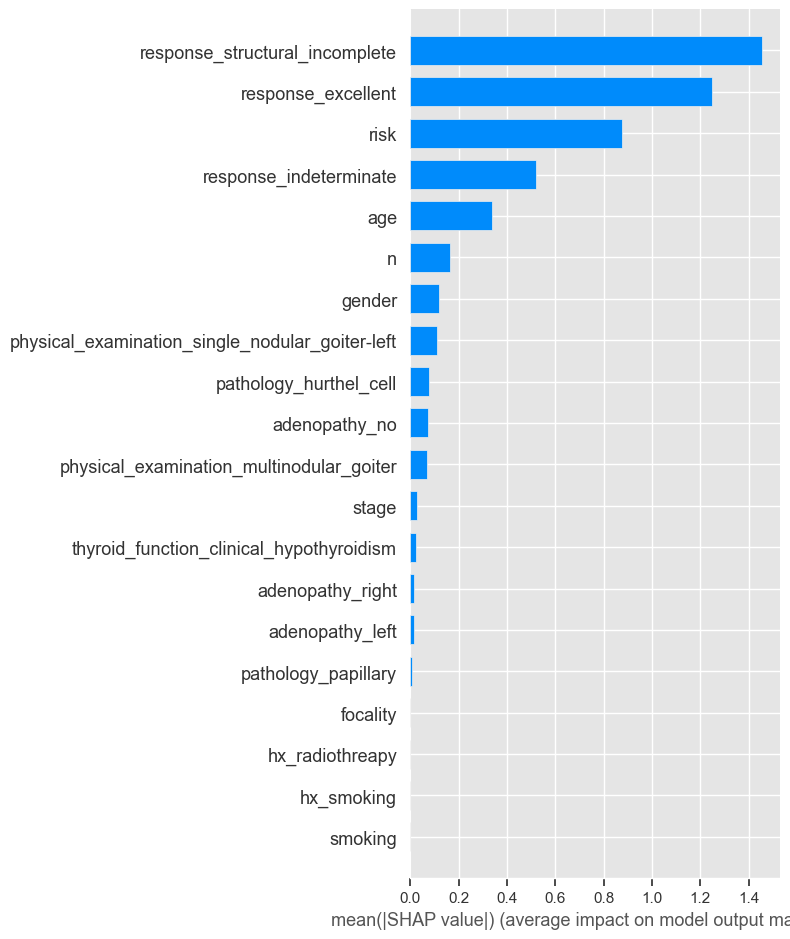

In [827]:
# SHAP initialisieren (optional, für Jupyter Notebooks)
shap.initjs()

#  SHAP-Werte für Random Forest
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_train)

#  SHAP Summary Plot (Bar)
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

#  SHAP-Werte für XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)

#  SHAP Summary Plot (Bar)
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")


In [828]:
# Bestes Modell für Entscheidungsbaum, Zufallswald und XGBoost definieren
best_tree = DecisionTreeClassifier(max_depth=5, random_state=42)  # Beispielwert, anpassen
best_rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Beispielwert, anpassen
best_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  # Beispielwert, anpassen

# Modelle trainieren (passende Trainingsdaten verwenden)
best_tree.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

#  Zielklassen: 0 = 'Nicht Rezidiviert', 1 = 'Rezidiviert'

#  Entscheidungsbaum: Vorhersagen für den Testdatensatz erstellen
y_pred1 = best_tree.predict(X_test)
report1 = classification_report(y_test, y_pred1, target_names=['Nicht Rezidiviert', 'Rezidiviert'])
print(" Klassifikationsbericht - Entscheidungsbaum")
print(report1)

#  Random Forest: Vorhersagen für den Testdatensatz erstellen
y_pred2 = best_rf.predict(X_test)
report2 = classification_report(y_test, y_pred2, target_names=['Nicht Rezidiviert', 'Rezidiviert'])
print(" Klassifikationsbericht - Random Forest")
print(report2)

#  XGBoost: Vorhersagen für den Testdatensatz erstellen (prüfen, ob y_pred3 existiert, falls nicht, erneut vorhersagen)
try:
    report3 = classification_report(y_test, y_pred3, target_names=['Nicht Rezidiviert', 'Rezidiviert'])
except NameError:
    y_pred3 = best_xgb.predict(X_test)
    report3 = classification_report(y_test, y_pred3, target_names=['Nicht Rezidiviert', 'Rezidiviert'])

print(" Klassifikationsbericht - XGBoost")
print(report3)

from sklearn.metrics import f1_score

# F1-Scores berechnen
f1_scores = {
    "Entscheidungsbaum": f1_score(y_test, y_pred1),
    "Random Forest": f1_score(y_test, y_pred2),
    "XGBoost": f1_score(y_test, y_pred3)
}

# Beste Modell ermitteln
best_model = max(f1_scores, key=f1_scores.get)
best_score = f1_scores[best_model]

print("\n==============================")
print("  Vergleich der F1-Scores")
for model, score in f1_scores.items():
    print(f"{model}: {score:.3f}")
print(f"\n  Bestes Modell basierend auf dem F1-Score: **{best_model}** ({best_score:.3f})")
print("==============================")



 Klassifikationsbericht - Entscheidungsbaum
                   precision    recall  f1-score   support

Nicht Rezidiviert       0.94      0.92      0.93        51
      Rezidiviert       0.83      0.86      0.84        22

         accuracy                           0.90        73
        macro avg       0.88      0.89      0.89        73
     weighted avg       0.91      0.90      0.90        73

 Klassifikationsbericht - Random Forest
                   precision    recall  f1-score   support

Nicht Rezidiviert       0.98      0.96      0.97        51
      Rezidiviert       0.91      0.95      0.93        22

         accuracy                           0.96        73
        macro avg       0.95      0.96      0.95        73
     weighted avg       0.96      0.96      0.96        73

 Klassifikationsbericht - XGBoost
                   precision    recall  f1-score   support

Nicht Rezidiviert       0.85      0.88      0.87        51
      Rezidiviert       0.70      0.64      0.67 

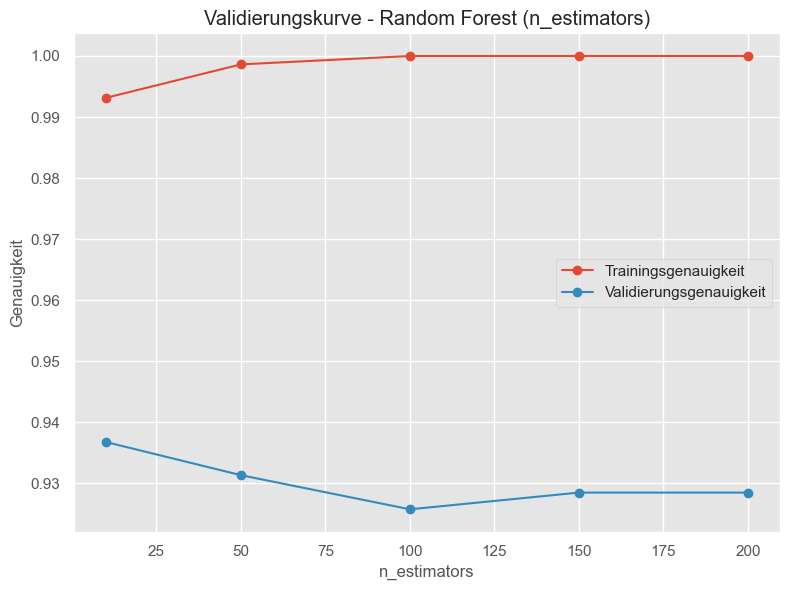

In [829]:
#  Warnings ignorieren (z.B. wegen Pickle-Versionskonflikten)
warnings.filterwarnings('ignore')

#  Plot-Funktion für Validierungskurve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=5, scoring='accuracy'):
    train_scores, test_scores = validation_curve(
        estimator, X, y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring,
        n_jobs=1  #  Wichtig: Kein Parallelprozess wegen Pickle-Problemen
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.plot(param_range, train_scores_mean, label='Trainingsgenauigkeit', marker='o')
    plt.plot(param_range, test_scores_mean, label='Validierungsgenauigkeit', marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Genauigkeit')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Modell vorbereiten
rf_model = RandomForestClassifier(random_state=42)

#  Anzahl der Bäume testen
param_range_rf = [10, 50, 100, 150, 200]

#  Kurve plotten
plot_validation_curve(
    estimator=rf_model,
    title='Validierungskurve - Random Forest (n_estimators)',
    X=X, y=y,
    param_name='n_estimators',
    param_range=param_range_rf,
    cv=5,
    scoring='accuracy'
)


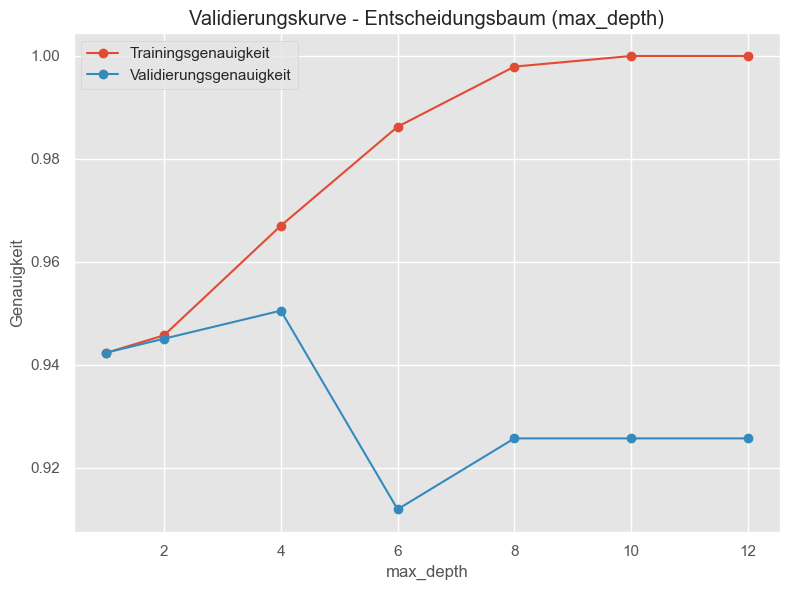

In [830]:
#  Plot-Funktion
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=5, scoring='accuracy'):
    from sklearn.model_selection import validation_curve



    train_scores, test_scores = validation_curve(
        estimator, X, y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring,
        n_jobs=1  #  Kein Parallel wegen Pickle-Problemen
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.plot(param_range, train_scores_mean, label='Trainingsgenauigkeit', marker='o')
    plt.plot(param_range, test_scores_mean, label='Validierungsgenauigkeit', marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Genauigkeit')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Validierungskurve für Entscheidungsbaum
estimator = DecisionTreeClassifier(random_state=42)  # Alternativ: model1 falls bereits trainiert
param_name = 'max_depth'
param_range = [1, 2, 4, 6, 8, 10, 12]

plot_validation_curve(
    estimator=estimator,
    title='Validierungskurve - Entscheidungsbaum (max_depth)',
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range
)
